In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import random
from scipy.signal import savgol_filter
from scipy.signal import peak_widths
from scipy.signal import find_peaks
from scipy.integrate import trapz
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [30]:
path_uv_ego = 'data/uv_ego/uv_ego.csv'

In [31]:
def extract_spectrophotometry_data(path, sep=';'):
    with open(path, 'r') as f:
        data = f.readlines()
        id_data = data[0]
        curves_id = [id for id in id_data.rstrip().split(';') if id]
        curves_id = {i: j for i, j in zip(range(1, len(curves_id) + 1), curves_id)}

        curves_data = data[2:]
        num_of_y_cols = len(data[2].split(sep)) // 2
        X = []
        Y = [[] for _ in range(num_of_y_cols)]
        for line in curves_data:
            line = [float(el.rstrip()) for el in line.split(';')]
            if line[0] == '':
                continue
            X.append(line[0])
            y_values = line[1::2]
            for i in range(len(y_values)):
                Y[i].append(y_values[i])
        return X, Y, curves_id

In [32]:
def normalize_data(data):
    mx, mn = max(data), min(data)
    for i, val in enumerate(data):
        val = round((val - mn) / (mx - mn), 4)
        data[i] = val
    return data

In [65]:
def find_width(y, height=0.1, prominence=0.02, rel_height=1):
    y = y[::-1]
    peaks, _ = find_peaks(y, height=height, prominence=prominence)
    result = peak_widths(y, peaks, rel_height=rel_height)
    width = result[1:]
    if len(width[0]) == 0:
        pass
    else:
        width = list(width)
        width[1] += X[-1]
        width[2] += X[-1]
        width = tuple(width)
    return width  # (y, x_min, x_max)

In [43]:
X, Y, sp_id = extract_spectrophotometry_data(path_uv_ego, sep=';')

In [44]:
X = list(filter(lambda x: x <= 380, X))

In [45]:
Y_smooth = [savgol_filter(y, window_length=73, polyorder=3) for y in Y]

In [46]:
Y_smooth = [normalize_data(y[-len(X):]) for y in Y_smooth]

In [47]:
P = []
X_m = []
Y_m = []
for i in range(len(Y_smooth)):
    p, _ = find_peaks(Y_smooth[i], height=0.1, prominence=0.02)
    x_m = [X[j] for j in p]
    y_m = [Y_smooth[i][j] for j in p]
    P.append(p)
    X_m.append(x_m)
    Y_m.append(y_m)

In [62]:
W = [find_width(y) for y in Y_smooth]

In [63]:
def generate_color():
    r, g, b = random(), random(), random()
    return (r, g, b)

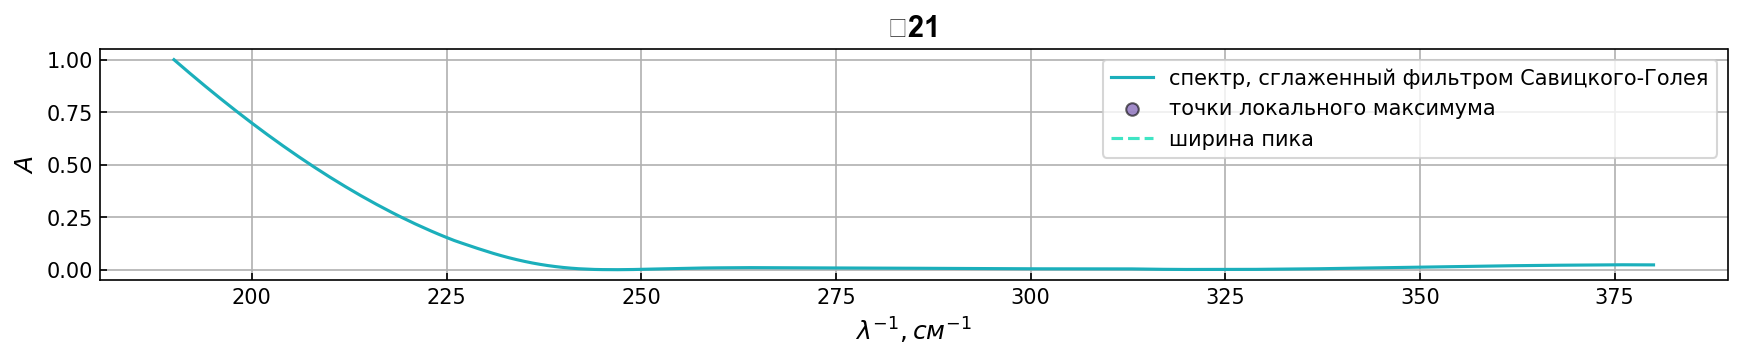

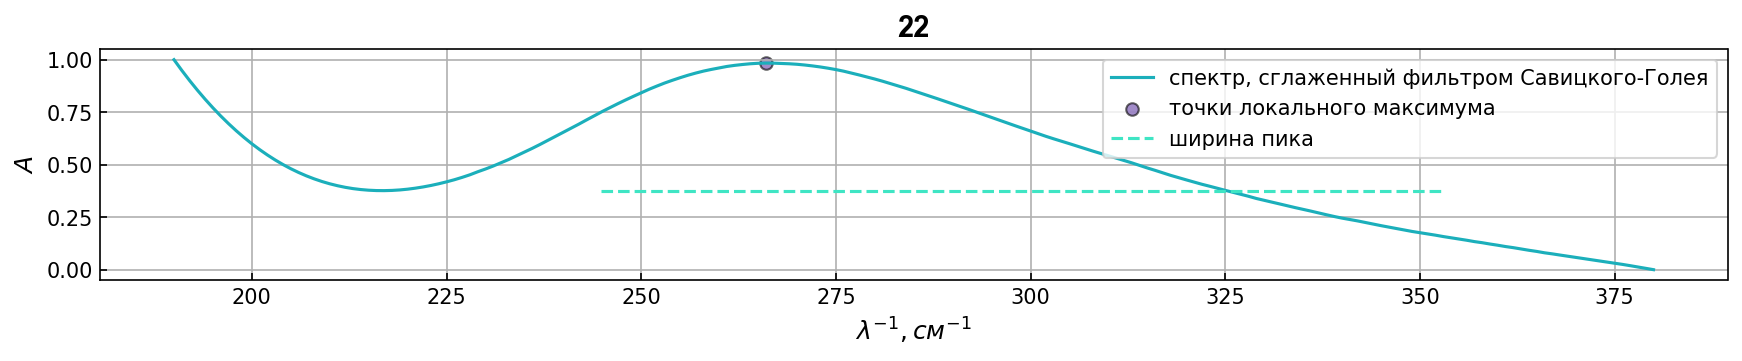

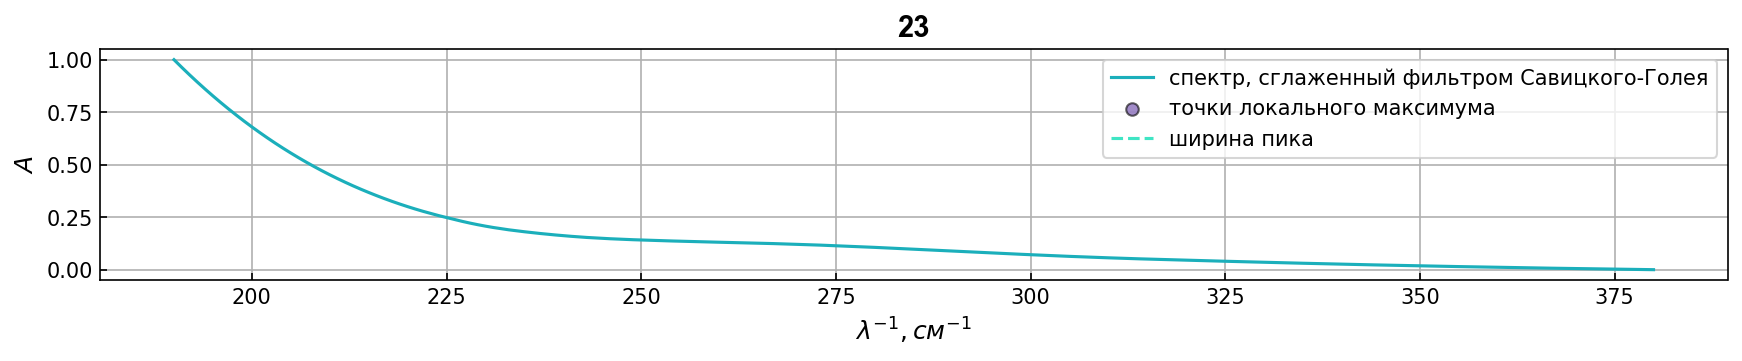

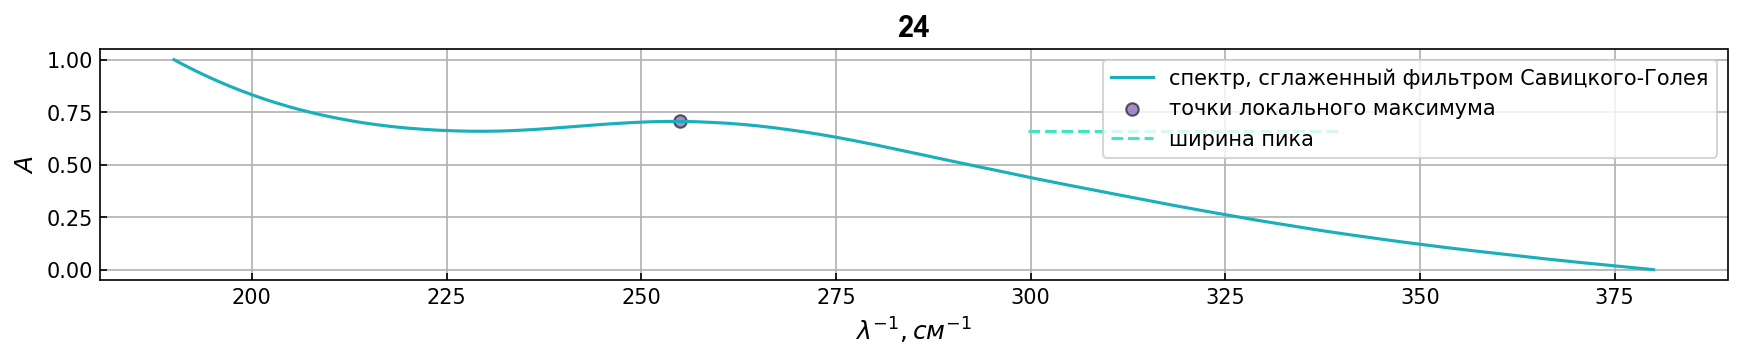

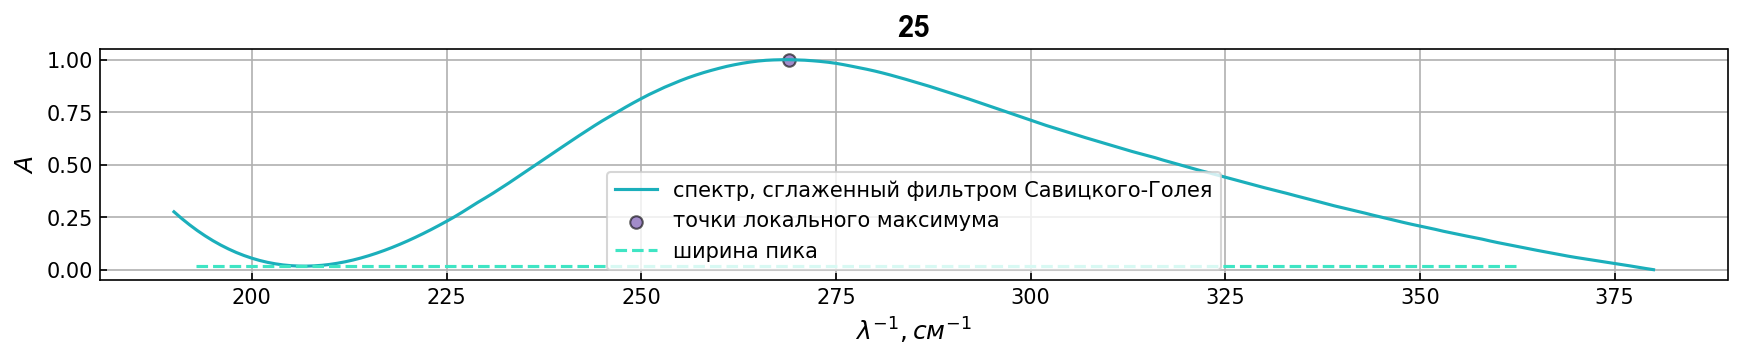

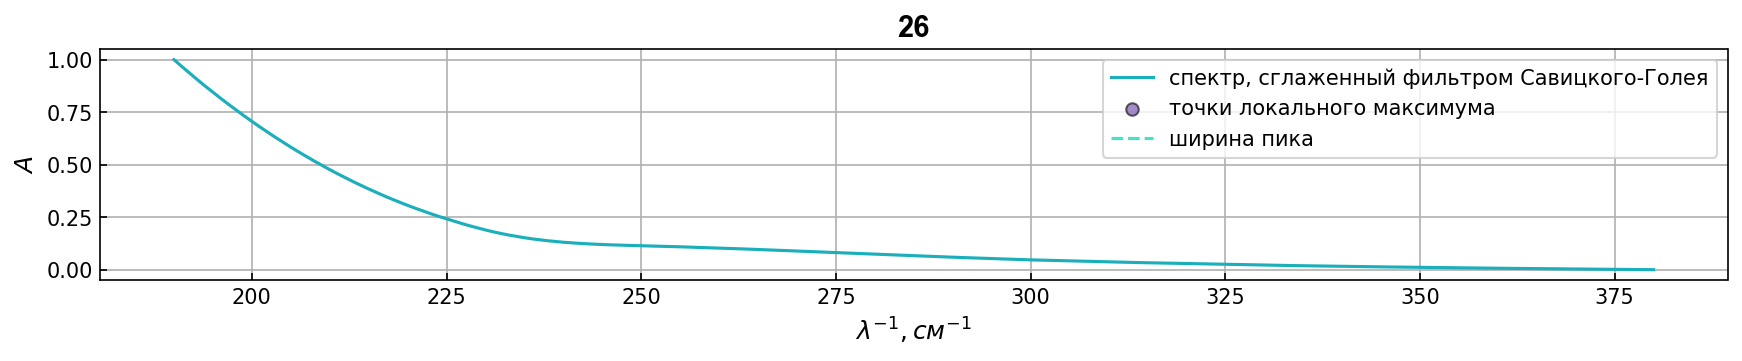

In [64]:
color1 = generate_color()
color2 = generate_color()
color3 = generate_color()

for i in range(len(Y_smooth)):
    fig = plt.figure(figsize=(14, 2), dpi=150, linewidth=1.0)
    plt.grid(True)
    plt.tick_params(direction='in')
    ax = fig.gca()
    ax.set_title(f'{sp_id[i+1]}', fontname='Arial', fontsize='14', fontweight='bold')
    ax.plot(X,
            Y_smooth[i],
            color=color1,
            linewidth=1.5,
            label='спектр, сглаженный фильтром Савицкого-Голея')
    ax.scatter(x=X_m[i],
                y=Y_m[i],
                marker='o',
                color=color3,
                edgecolor='black',
                alpha=0.6,
                label='точки локального максимума')
    ax.hlines(*W[i],
          linewidth=1.5,
          linestyle='dashed',
          color=color2,
          label='ширина пика')
    ax.set_xlabel('$λ^{-1}, см^{-1}$', fontname='Arial', fontsize=12)
    ax.set_ylabel('$A$', fontname='Arial', fontsize=12)
    plt.legend()
    plt.show()

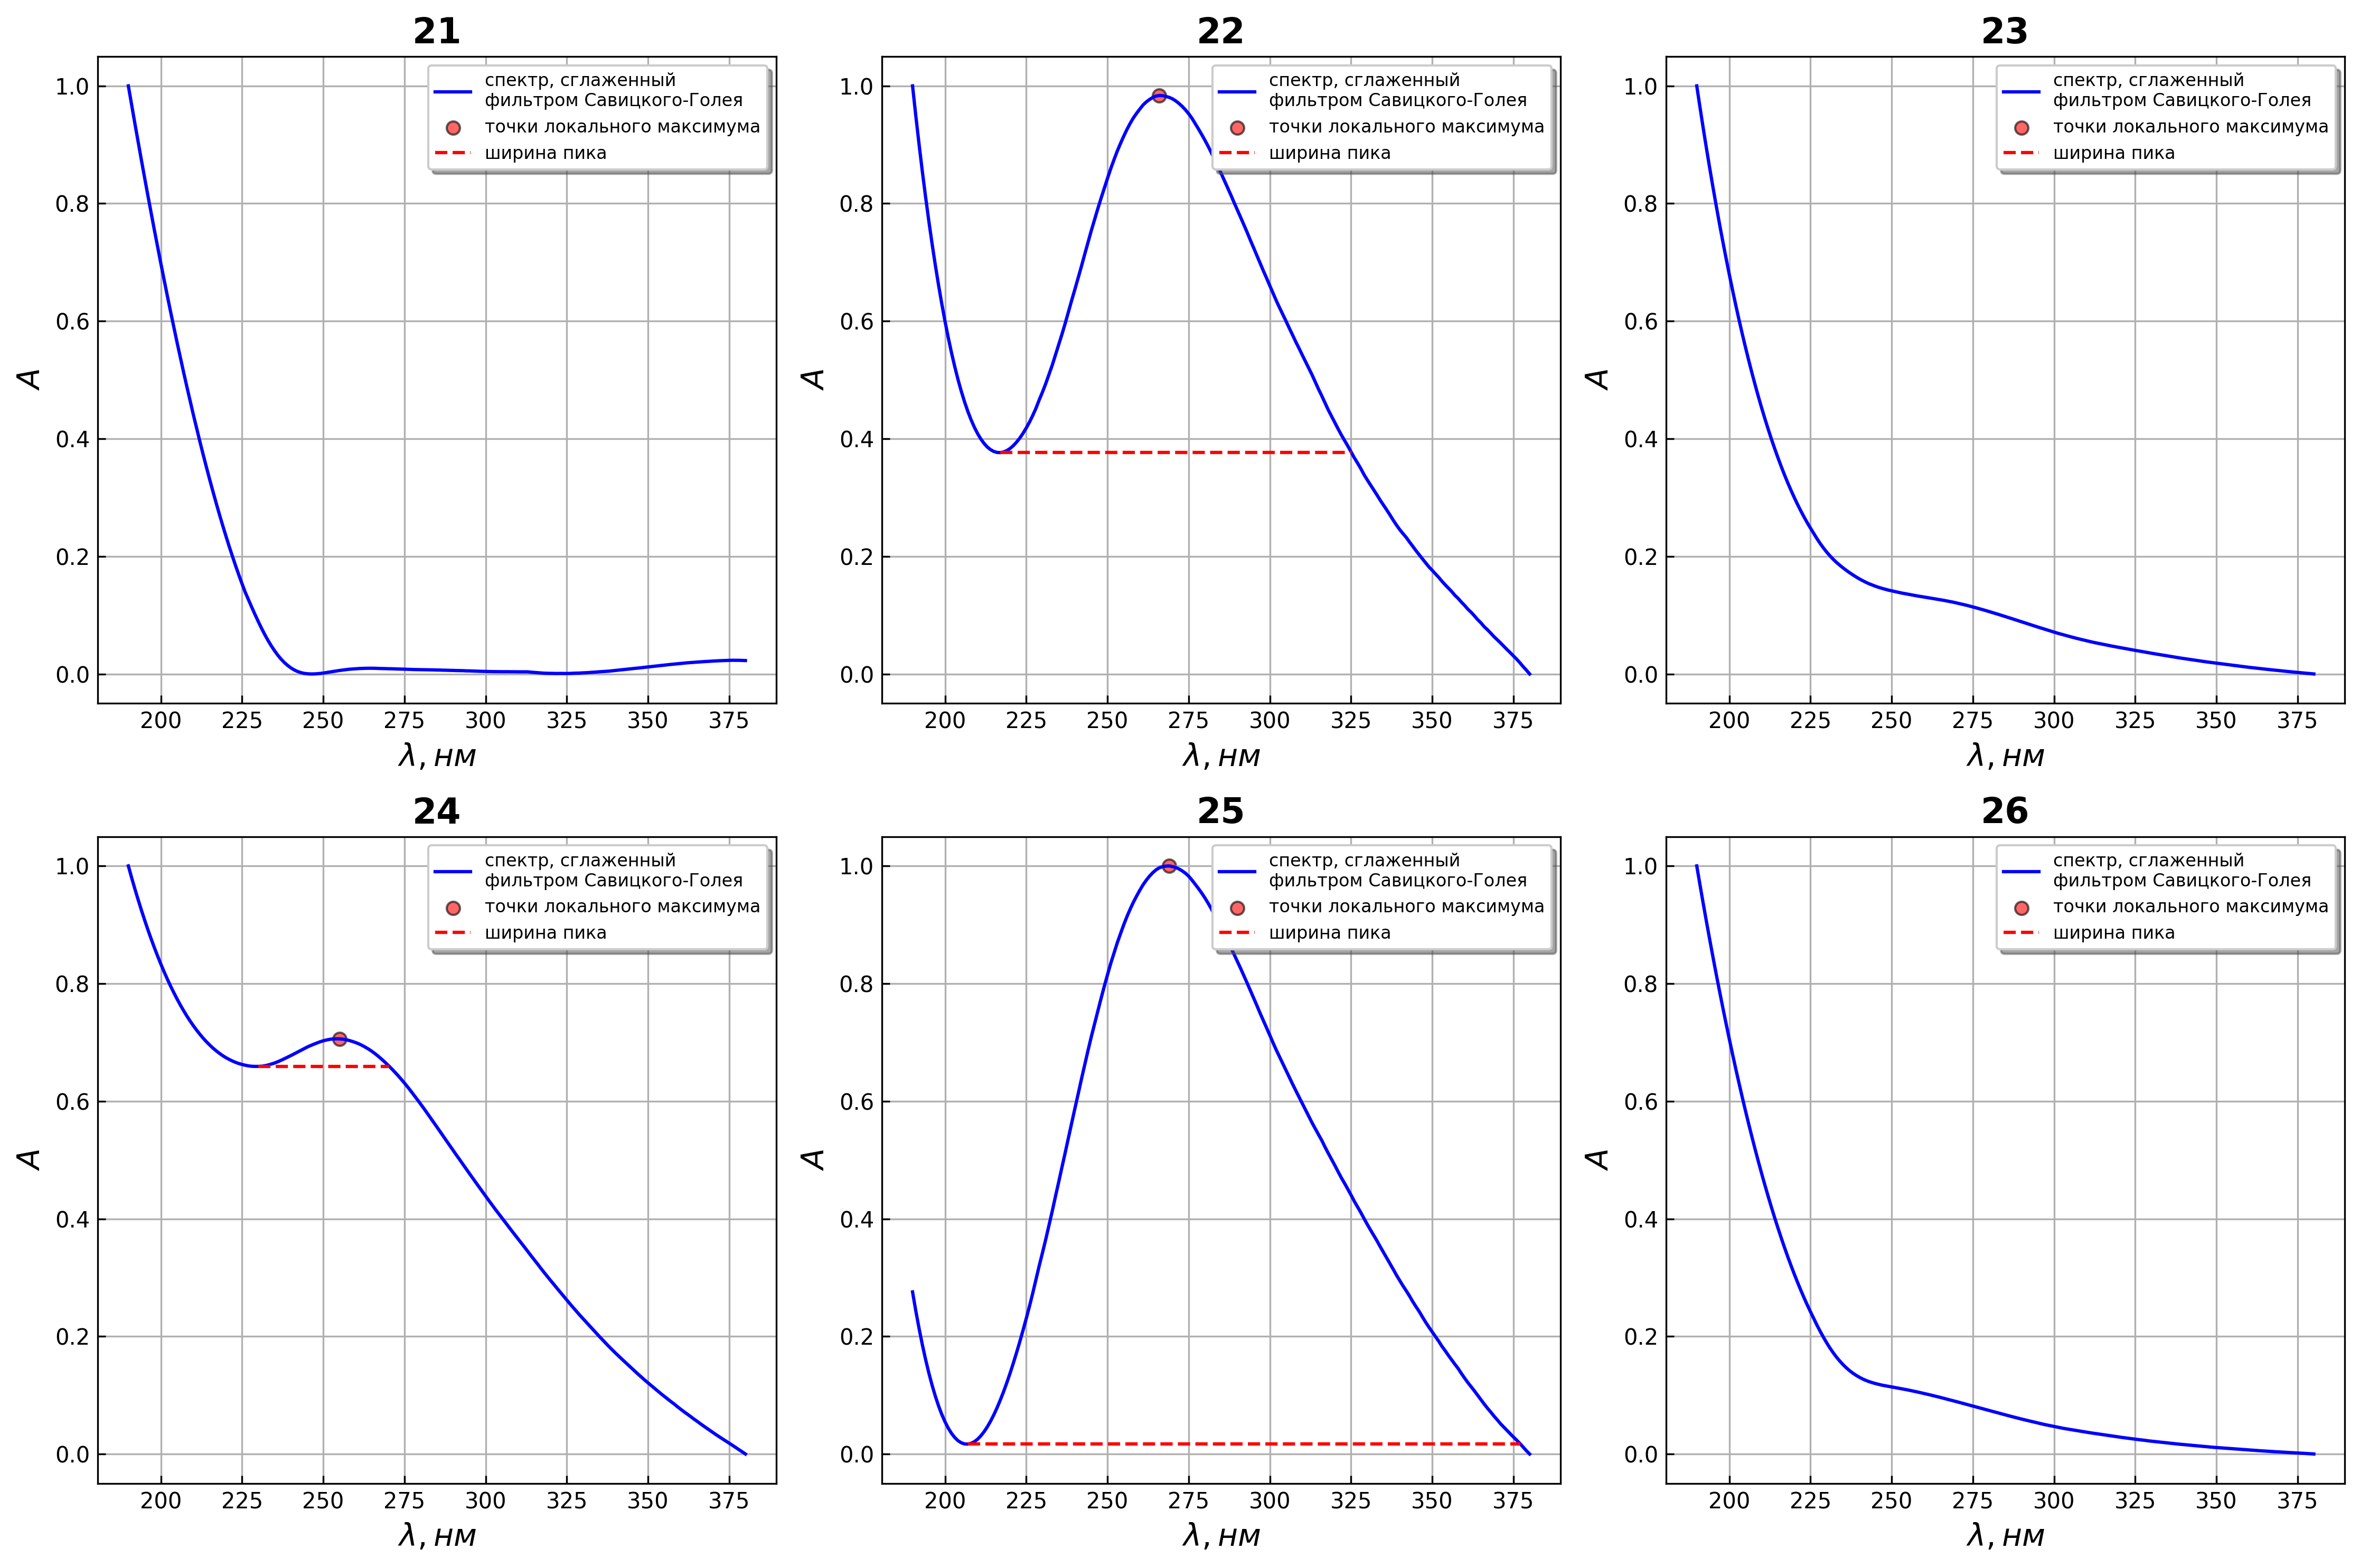

In [55]:
color1 = 'blue'  # generate_color()
color2 = 'red'  # generate_color()

nrows = 2
ncols = 3
index = 1

fig = plt.figure(figsize=(15, 10), dpi=300, linewidth=1.0)

for i in range(len(Y_smooth)):
    plt.subplot(nrows, ncols, index)
    plt.grid(True)
    plt.tick_params(direction='in')
    ax = fig.gca()
    ax.set_title(sp_id[i+1], fontname='DejaVu Sans', fontsize=16, fontweight='bold')
    ax.plot(X,
            Y_smooth[i],
            color=color1,
            linewidth=1.5,
            label='спектр, сглаженный \nфильтром Савицкого-Голея')
    ax.scatter(x=X_m[i],
                y=Y_m[i],
                marker='o',
                color=color2,
                edgecolor='black',
                alpha=0.6,
                label='точки локального максимума')
    ax.hlines(*W[i],
              linewidth=1.5,
              linestyle='dashed',
              color=color2,
              label='ширина пика')
    ax.set_xlabel('$λ, нм$', fontname='DejaVu Sans', fontsize=14)
    ax.set_ylabel('$A$', fontname='DejaVu Sans', fontsize=14)
    plt.legend(loc='upper right', fancybox=True, shadow=True, prop={'size': 8})
    index += 1
plt.tight_layout()
plt.savefig('results/uv_ego/all_uv_spectra.png')
plt.show()

In [18]:
def reduce_dimensions_pca(data, n_components=2):
    pca = PCA(n_components=n_components).fit(data)
    explained_variance = pca.explained_variance_ratio_
    data = pca.transform(data)
    data_dict = {}
    for i in range(n_components):
        data_dict[f'principal_component_{i+1}'] = data[:, i]
    data = pd.DataFrame(data_dict)
    explained_variance = [round(var, 4) for var in explained_variance]
    return data, explained_variance

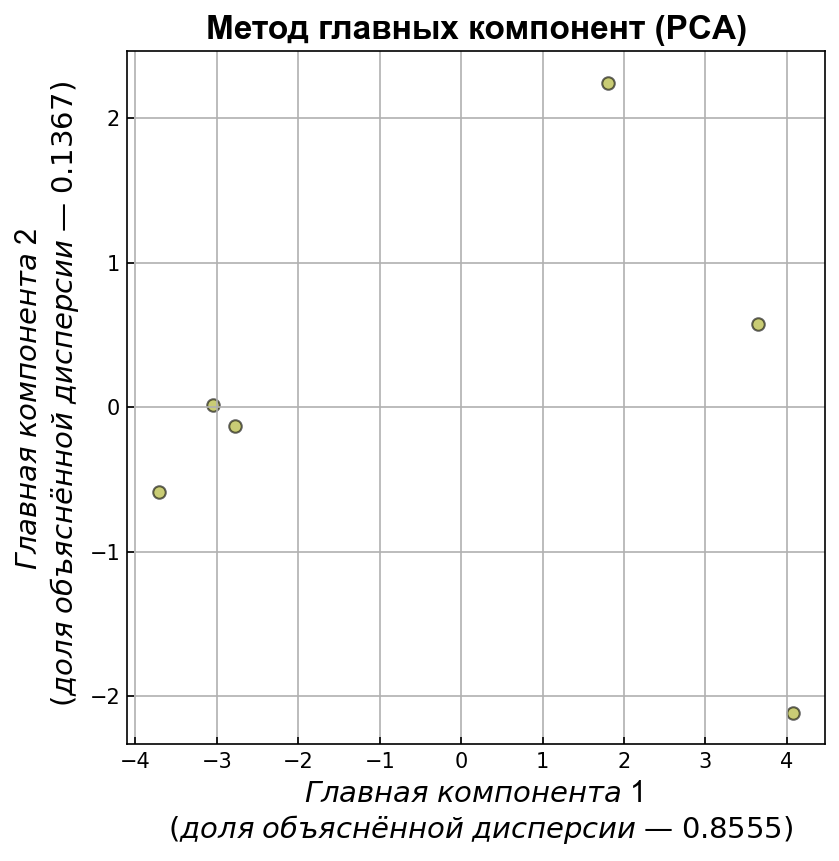

In [19]:
sp_array_pca, expl_variance = reduce_dimensions_pca(Y_smooth)

sp_arr_pca_x = list(sp_array_pca.iloc[:, 0])
sp_arr_pca_y = list(sp_array_pca.iloc[:, 1])

fig = plt.figure(figsize=(6, 6), dpi=150, linewidth=1.0)
plt.grid(True)
plt.tick_params(direction='in')
ax = fig.gca()
ax.set_title('Метод главных компонент (PCA)', fontname='Arial', fontsize=16, fontweight='bold')
ax.scatter(x=sp_arr_pca_x,
           y=sp_arr_pca_y,
           marker='o',
           color=generate_color(),
           edgecolor='black',
           alpha=0.6,
           label='')
x_label = f'$Главная$ $компонента$ 1 \n $(доля$ $объяснённой$ $дисперсии$ — ${expl_variance[0]})$'
y_label = f'$Главная$ $компонента$ 2 \n $(доля$ $объяснённой$ $дисперсии$ — ${expl_variance[1]})$' 
ax.set_xlabel(x_label, fontname='Arial', fontsize=14)
ax.set_ylabel(y_label, fontname='Arial', fontsize=14)

plt.show()

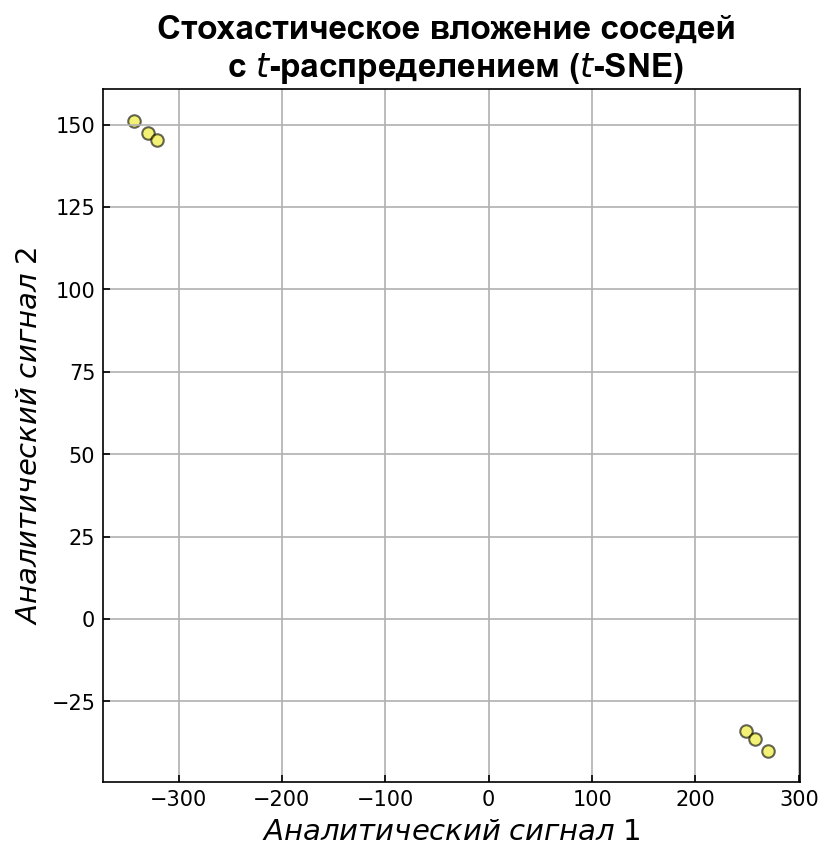

In [20]:
tsne = TSNE(n_components=2, learning_rate=100, init='pca', random_state=42, perplexity=1, n_iter=100_000)
sp_arr_tsne = tsne.fit_transform(np.array(Y_smooth))

sp_arr_tsne_x = list(sp_arr_tsne[:, 0])
sp_arr_tsne_y = list(sp_arr_tsne[:, 1])

fig = plt.figure(figsize=(6, 6), dpi=150, linewidth=1.0)
plt.grid(True)
plt.tick_params(direction='in')
ax = fig.gca()
ax.set_title('Стохастическое вложение соседей \n с $t$-распределением ($t$-SNE)',
             fontname='Arial', fontsize=16, fontweight='bold')
ax.scatter(x=sp_arr_tsne_x,
           y=sp_arr_tsne_y,
           marker='o',
           color=generate_color(),
           edgecolor='black',
           alpha=0.6,
           label='')
x_label = '$Аналитический$ $сигнал$ $1$'
y_label = '$Аналитический$ $сигнал$ $2$'
ax.set_xlabel(x_label, fontname='Arial', fontsize=14)
ax.set_ylabel(y_label, fontname='Arial', fontsize=14)

plt.show()

In [21]:
'''UMAP IS UNAVAILABLE FOR PYTHON 3.11'''

# umap = UMAP(n_components=2, n_neighbors=2, min_dist=0.1, random_state=42)
# sp_arr_umap = umap.fit_transform(Y_smooth)

# sp_arr_umap_x = list(sp_arr_umap[:, 0])
# sp_arr_umap_y = list(sp_arr_umap[:, 1])

# fig = plt.figure(figsize=(9, 9), dpi=150, linewidth=1.0)
# plt.grid(True)
# plt.tick_params(direction='in')
# ax = fig.gca()
# ax.set_title('Метод UMAP',
#              fontname='DejaVu Sans', fontsize=16, fontweight='bold')
# ax.scatter(x=sp_arr_umap_x,
#            y=sp_arr_umap_y,
#            marker='o',
#            color=generate_color(),
#            edgecolor='black',
#            alpha=0.6,
#            label='')
# x_label = '$Аналитический$ $сигнал$ $1$'
# y_label = '$Аналитический$ $сигнал$ $2$'
# ax.set_xlabel(x_label, fontname='DejaVu Sans', fontsize=14)
# ax.set_ylabel(y_label, fontname='DejaVu Sans', fontsize=14)

# plt.show()

'UMAP IS UNAVAILABLE FOR PYTHON 3.11'

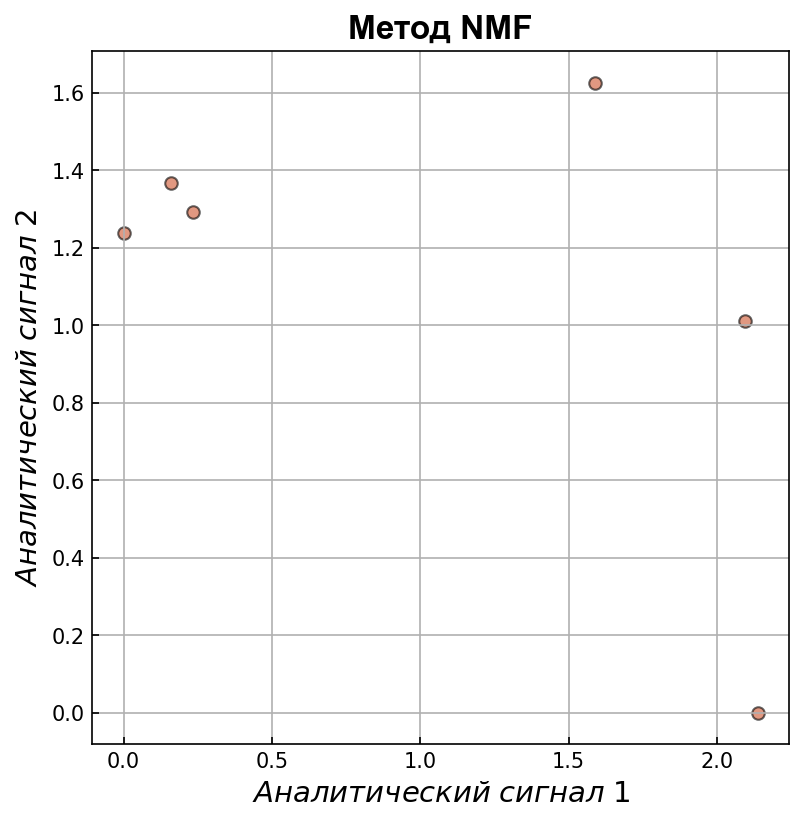

In [27]:
nmf = NMF(n_components=2, init='nndsvd', max_iter=100_000, random_state=42)
sp_arr_nmf = nmf.fit_transform(Y_smooth)

sp_arr_nmf_x = list(sp_arr_nmf[:, 0])
sp_arr_nmf_y = list(sp_arr_nmf[:, 1])

fig = plt.figure(figsize=(6, 6), dpi=150, linewidth=1.0)
plt.grid(True)
plt.tick_params(direction='in')
ax = fig.gca()
ax.set_title('Метод NMF',
             fontname='Arial', fontsize=16, fontweight='bold')
ax.scatter(x=sp_arr_nmf_x,
           y=sp_arr_nmf_y,
           marker='o',
           color=generate_color(),
           edgecolor='black',
           alpha=0.6,
           label='')
x_label = '$Аналитический$ $сигнал$ $1$'
y_label = '$Аналитический$ $сигнал$ $2$'
ax.set_xlabel(x_label, fontname='Arial', fontsize=14)
ax.set_ylabel(y_label, fontname='Arial', fontsize=14)

plt.show()

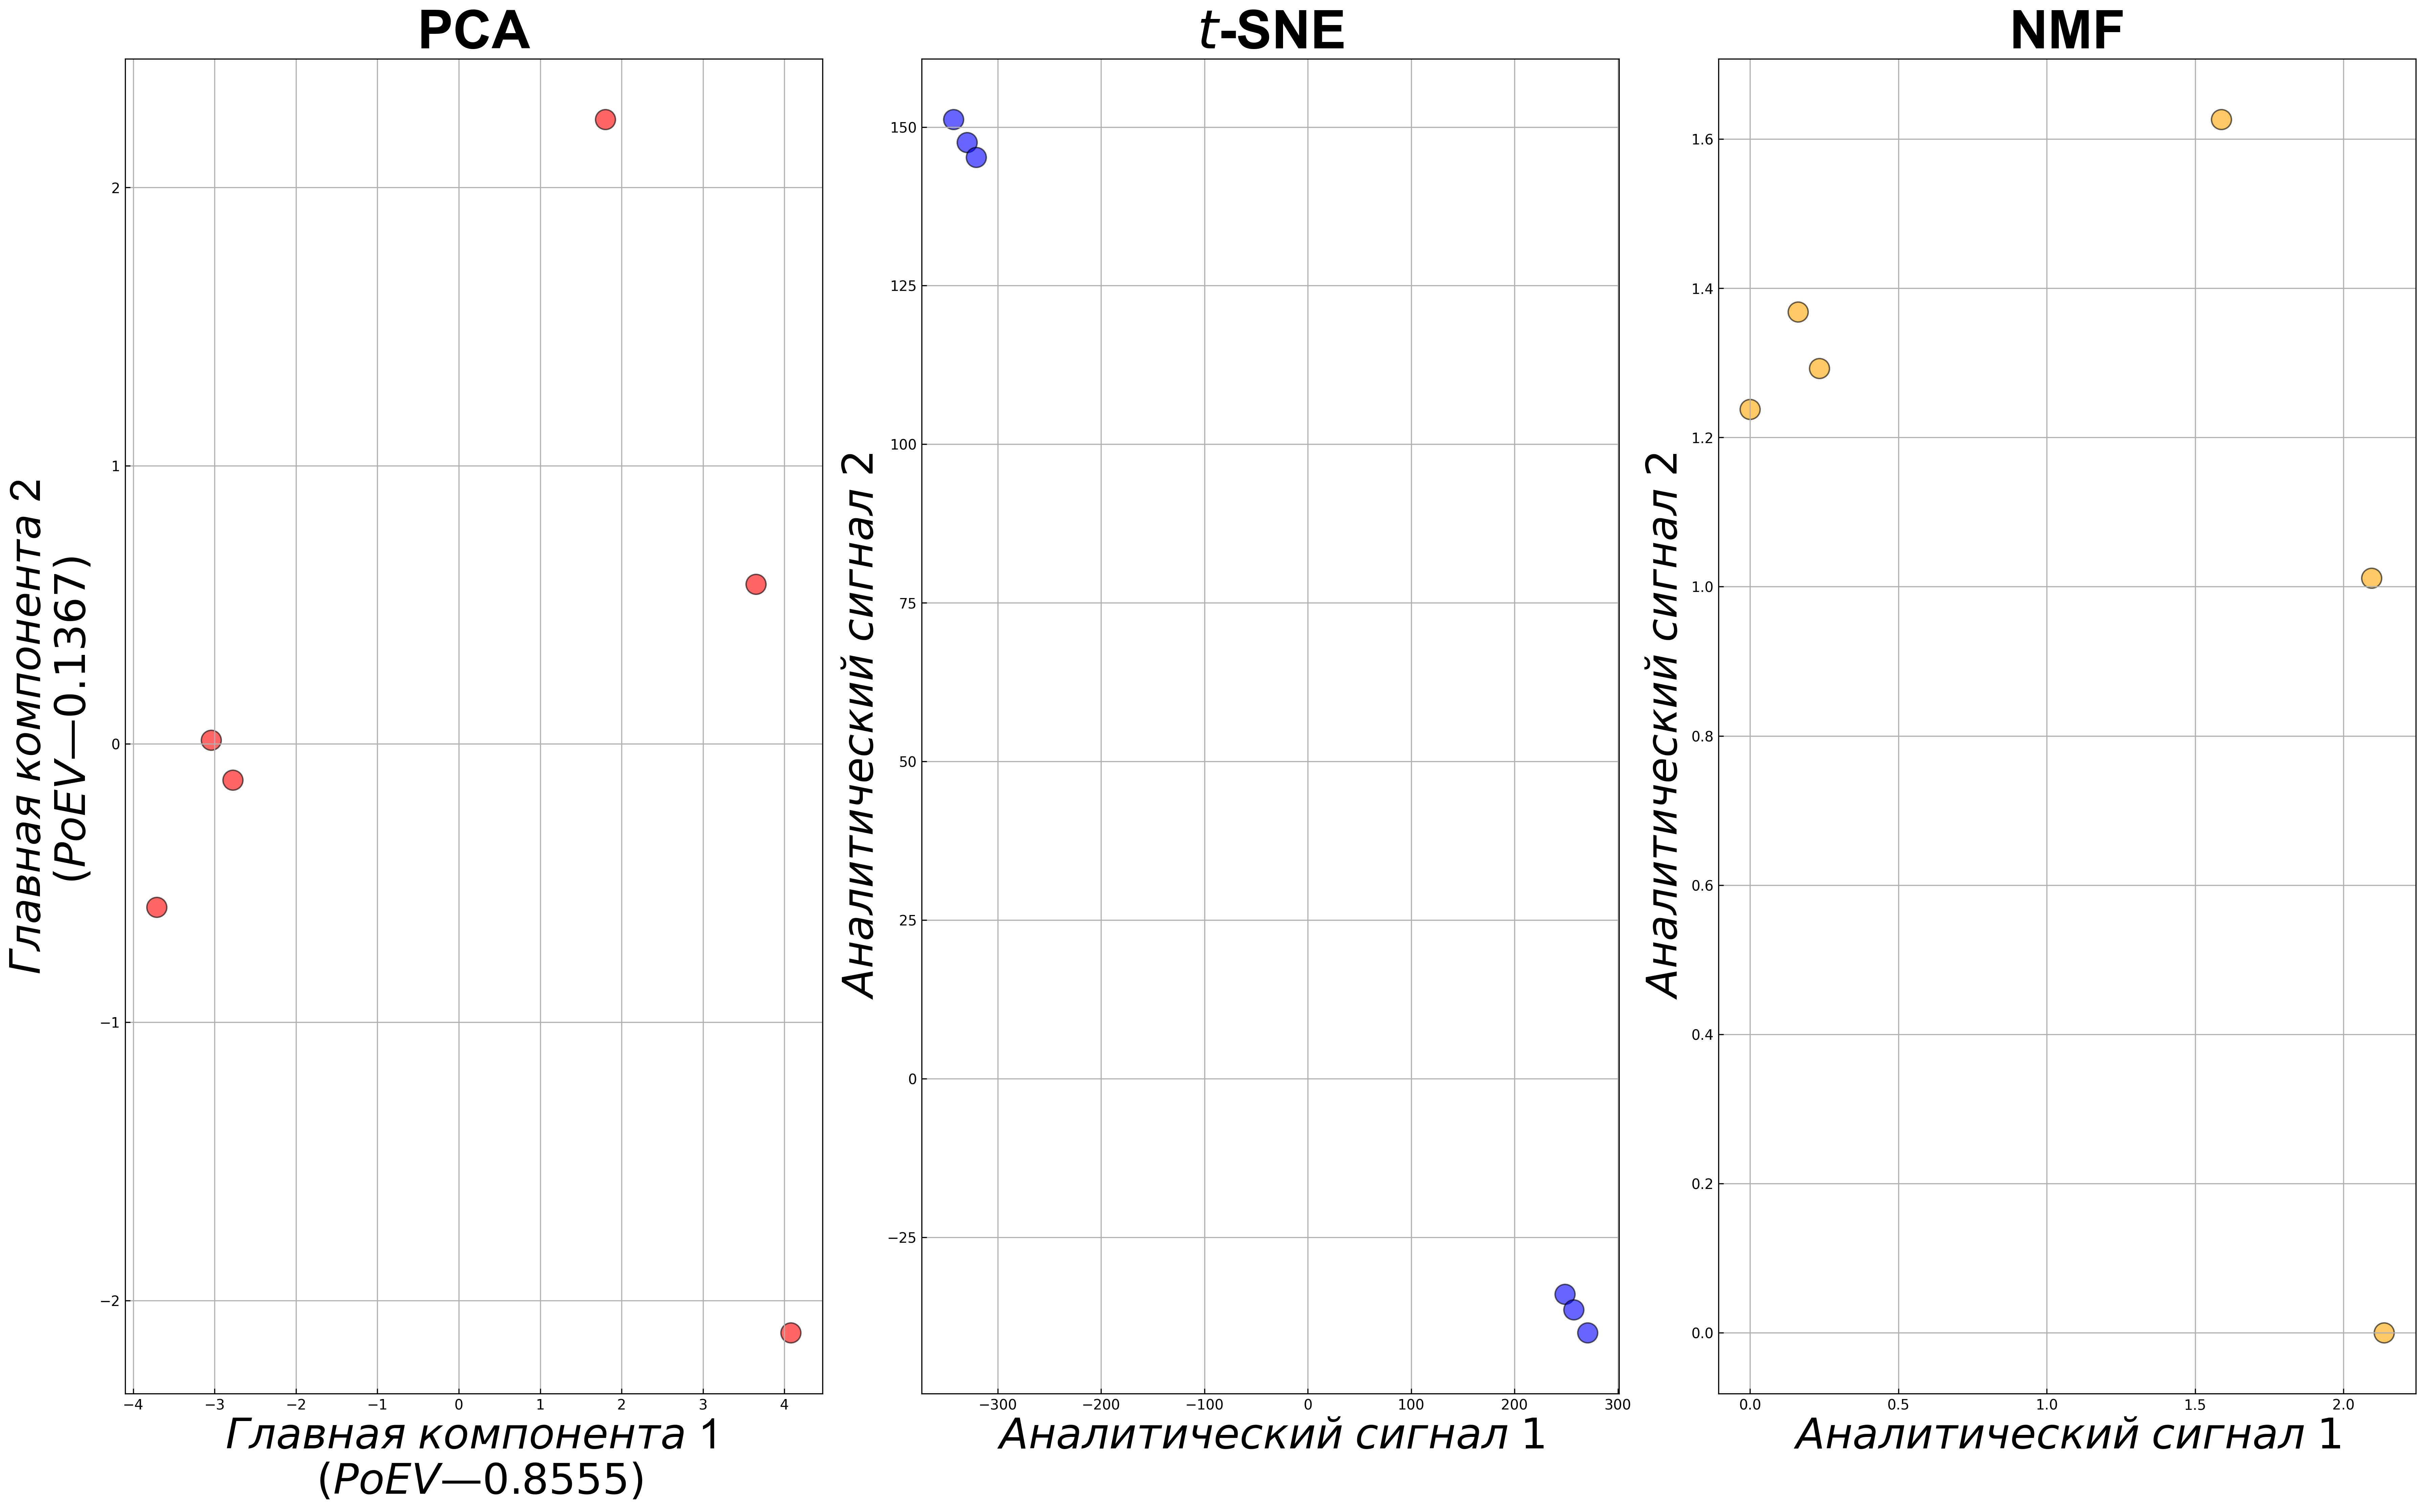

In [28]:
fig = plt.figure(figsize=(24, 15), dpi=300, linewidth=1.0)

nrows = 1
ncols = 3

plt.subplot(nrows, ncols, 1)
plt.grid(True)
plt.tick_params(direction='in')
ax = fig.gca()
ax.set_title('PCA', fontname='Arial', fontsize=38, fontweight='bold')
ax.scatter(x=sp_arr_pca_x,
           y=sp_arr_pca_y,
           marker='o',
           color='red',
           s=200.0,
           edgecolor='black',
           alpha=0.6,
           label='')
x_label = f'$Главная$ $компонента$ 1 \n $(PoEV — {expl_variance[0]})$'
y_label = f'$Главная$ $компонента$ 2 \n $(PoEV — {expl_variance[1]})$' 
ax.set_xlabel(x_label, fontname='Arial', fontsize=30)
ax.set_ylabel(y_label, fontname='Arial', fontsize=30)

plt.subplot(nrows, ncols, 2)
plt.grid(True)
plt.tick_params(direction='in')
ax = fig.gca()
ax.set_title('$t$-SNE',
             fontname='Arial', fontsize=38, fontweight='bold')
ax.scatter(x=sp_arr_tsne_x,
           y=sp_arr_tsne_y,
           marker='o',
           color='blue',
           s=200.0,
           edgecolor='black',
           alpha=0.6,
           label='')
x_label = '$Аналитический$ $сигнал$ $1$'
y_label = '$Аналитический$ $сигнал$ $2$'
ax.set_xlabel(x_label, fontname='Arial', fontsize=30)
ax.set_ylabel(y_label, fontname='Arial', fontsize=30)

plt.subplot(nrows, ncols, 3)
plt.grid(True)
plt.tick_params(direction='in')
ax = fig.gca()
ax.set_title('NMF',
             fontname='Arial', fontsize=38, fontweight='bold')
ax.scatter(x=sp_arr_nmf_x,
           y=sp_arr_nmf_y,
           marker='o',
           color='orange',
           s=200.0,
           edgecolor='black',
           alpha=0.6,
           label='')
x_label = '$Аналитический$ $сигнал$ $1$'
y_label = '$Аналитический$ $сигнал$ $2$'
ax.set_xlabel(x_label, fontname='Arial', fontsize=30)
ax.set_ylabel(y_label, fontname='Arial', fontsize=30)
plt.tight_layout()

plt.savefig('results/uv_ego/uv_pca_tsne_umap.png', dpi=300)
plt.show()

In [56]:
def find_derivative(x, y):
    diff_lst = []
    for i in range(1, len(y)):
        diff = (y[i] - y[i-1]) / (x[i] - x[i-1])
        diff_lst.append(diff)
    return diff_lst

In [57]:
def minimum_finder(lst, crit_value=None):
    indexes = []
    minimum = []
    for i in range(1, len(lst)-1):
        if lst[i-1] > lst[i] and lst[i] < lst[i+1]:
            if crit_value is None or lst[i] > crit_value:
                if len(indexes) == 0:
                    indexes.append(i)
                    minimum.append(lst[i])
                elif abs(i - indexes[-1]) >= 45:
                    indexes.append(i)
                    minimum.append(lst[i])
                else:
                    pass
    return indexes, minimum

In [181]:
Y_der1 = [find_derivative(X, y) for y in Y]
Y_der1 = [normalize_data(y) for y in Y_smooth_der1_smooth]

In [182]:
Y_der1_smooth = [savgol_filter(y, window_length=53, polyorder=3) for y in Y_der1]
Y_der1_smooth = [normalize_data(y) for y in Y_smooth_der1_smooth]

In [183]:
Y_smooth_der1 = [find_derivative(X, y) for y in Y_smooth]
Y_smooth_der1 = [normalize_data(y) for y in Y_smooth_der1_smooth]

In [184]:
Y_smooth_der1_smooth = [savgol_filter(y, window_length=53, polyorder=3) for y in Y_smooth_der1]
Y_smooth_der1_smooth = [normalize_data(y) for y in Y_smooth_der1_smooth]

In [185]:
P = []
X_max = []
Y_max = []

for i in range(len(Y_smooth)):
    p, _ = find_peaks(Y_smooth_der1_smooth[i], height=0.1, prominence=0.1)
    x_m = [X[j] for j in p]
    y_m = [Y_smooth_der1_smooth[i][j] for j in p]
    P.append(p)
    X_max.append(x_m)
    Y_max.append(y_m)

In [188]:
W = [find_width(y, prominence=0.1) for y in Y_smooth_der1_smooth]

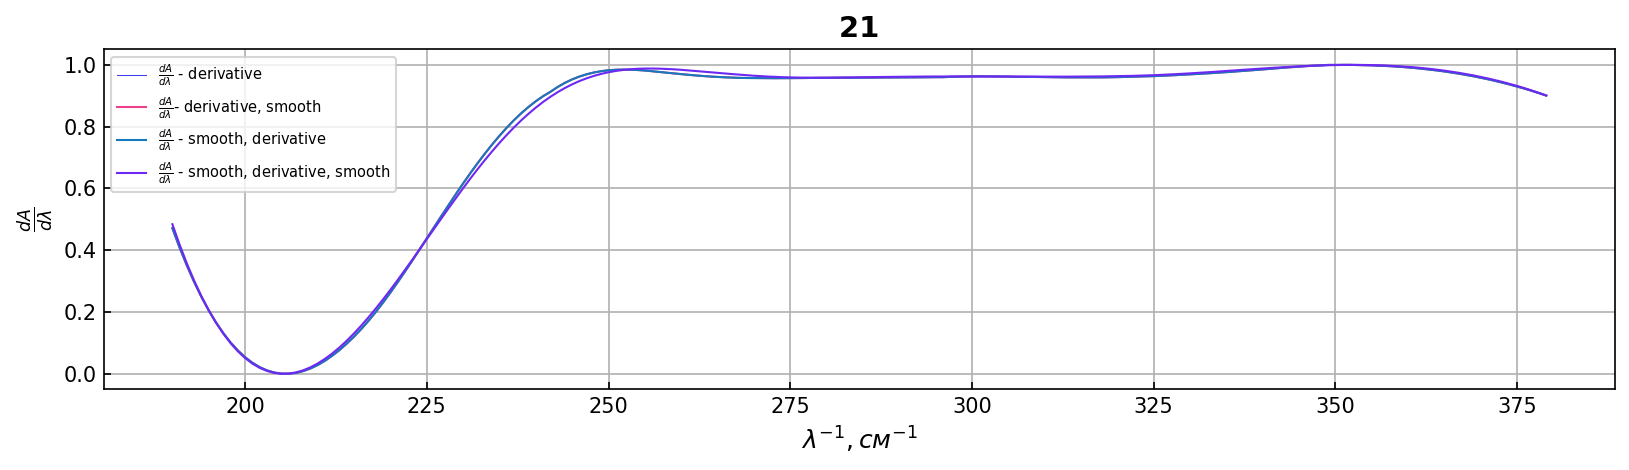

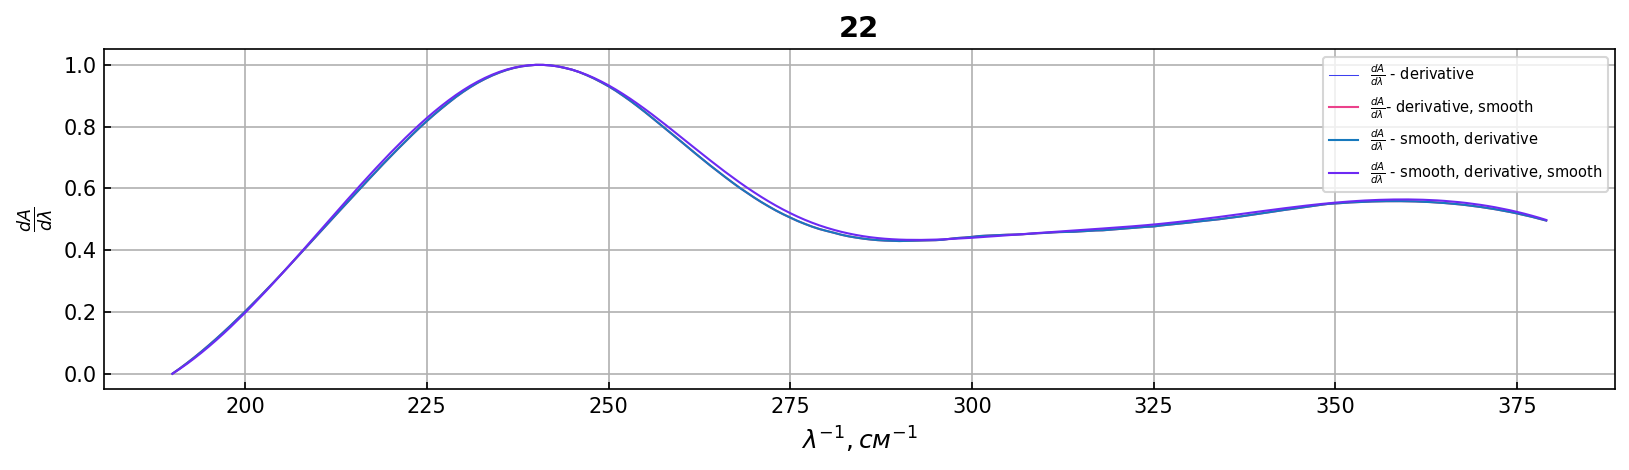

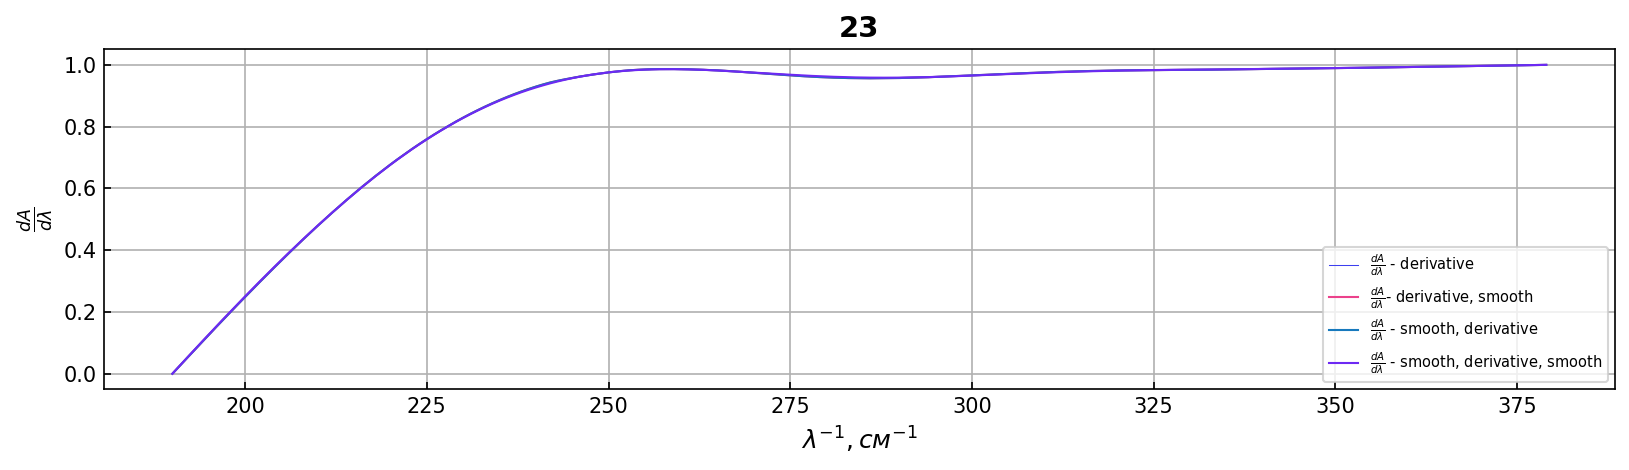

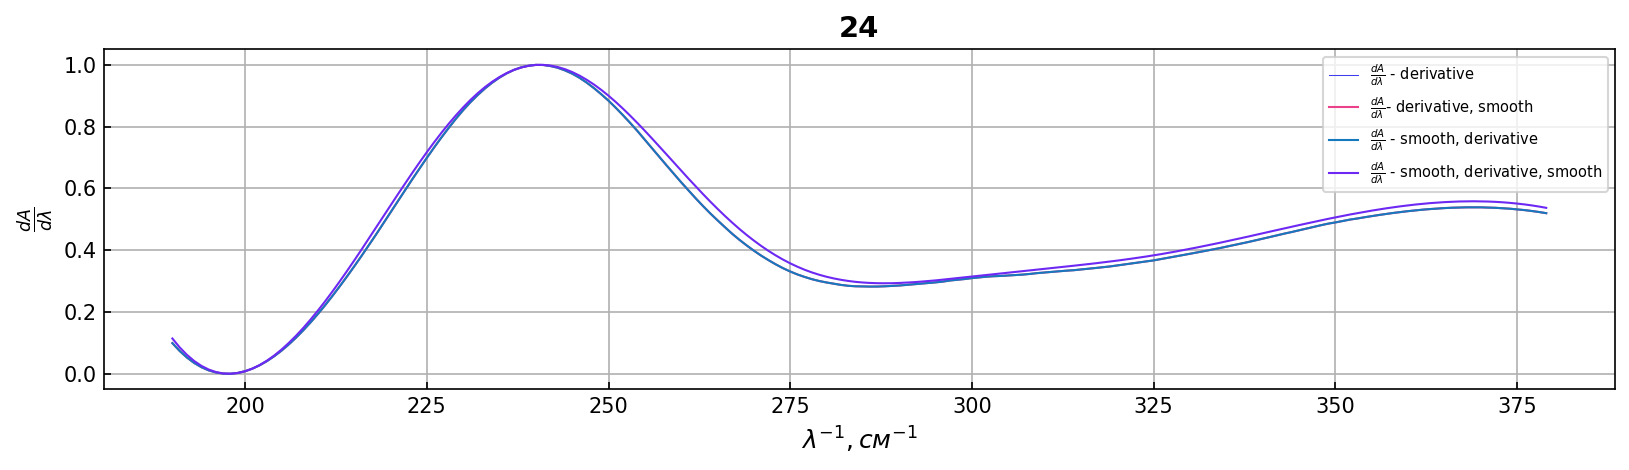

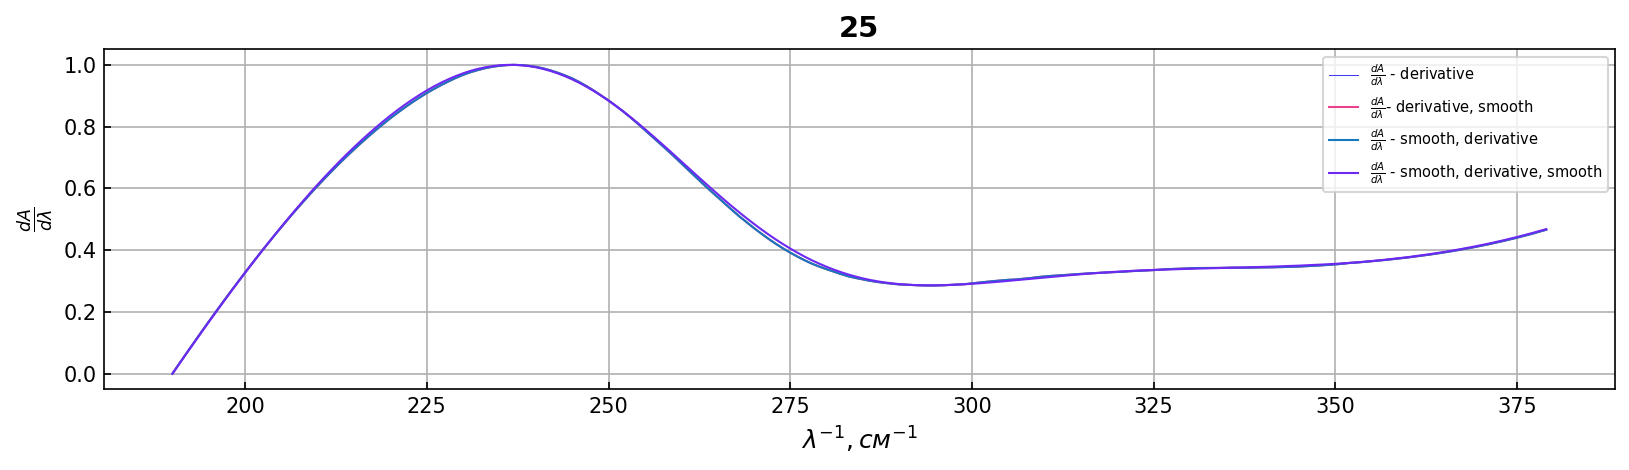

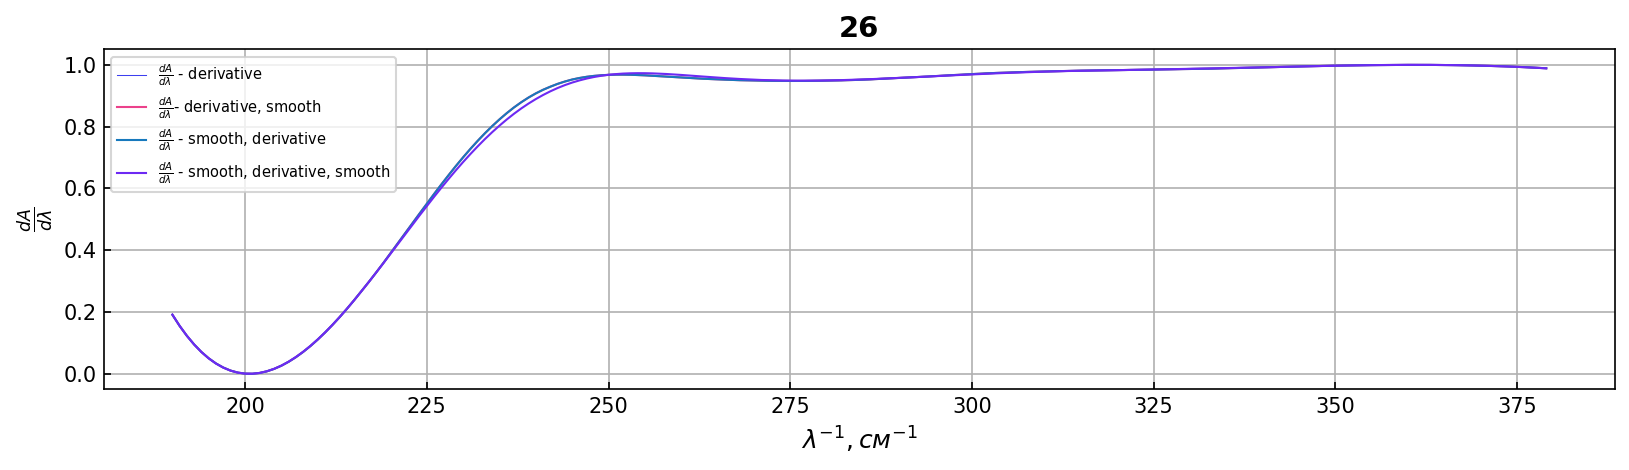

In [187]:
color1 = generate_color()
color2 = generate_color()
color3 = generate_color()
color4 = generate_color()
color5 = generate_color()

for i in range(len(Y)):
    fig = plt.figure(figsize=(13, 3), dpi=150, linewidth=1.0)
    plt.grid(True)
    plt.tick_params(direction='in')
    ax = fig.gca()
    ax.set_title(f'{sp_id[i+1]}', fontname='DejaVu Sans', fontsize=14, fontweight='bold')
    ax.plot(X[1:],
            Y_der1[i],
            color=color1,
            linewidth=0.5,
            label='$\\frac{dA}{dλ}$' + ' - derivative')
    ax.plot(X[1:],
            Y_der1_smooth[i],
            color=color2,
            linewidth=1.0,
            label='$\\frac{dA}{dλ}$' + '- derivative, smooth')
    ax.plot(X[1:],
            Y_smooth_der1[i],
            color=color3,
            linewidth=1.0,
            label='$\\frac{dA}{dλ}$' + ' - smooth, derivative')
    ax.plot(X[1:],
            Y_smooth_der1_smooth[i],
            color=color4,
            linewidth=1.0,
            label='$\\frac{dA}{dλ}$' + ' - smooth, derivative, smooth')
    
    ax.set_xlabel('$λ^{-1}, см^{-1}$', fontname='DejaVu Sans', fontsize=12)
    ax.set_ylabel('$\\frac{dA}{dλ}$', fontname='DejaVu Sans', fontsize=12)
    plt.legend(prop={'size': 7})
    plt.show()

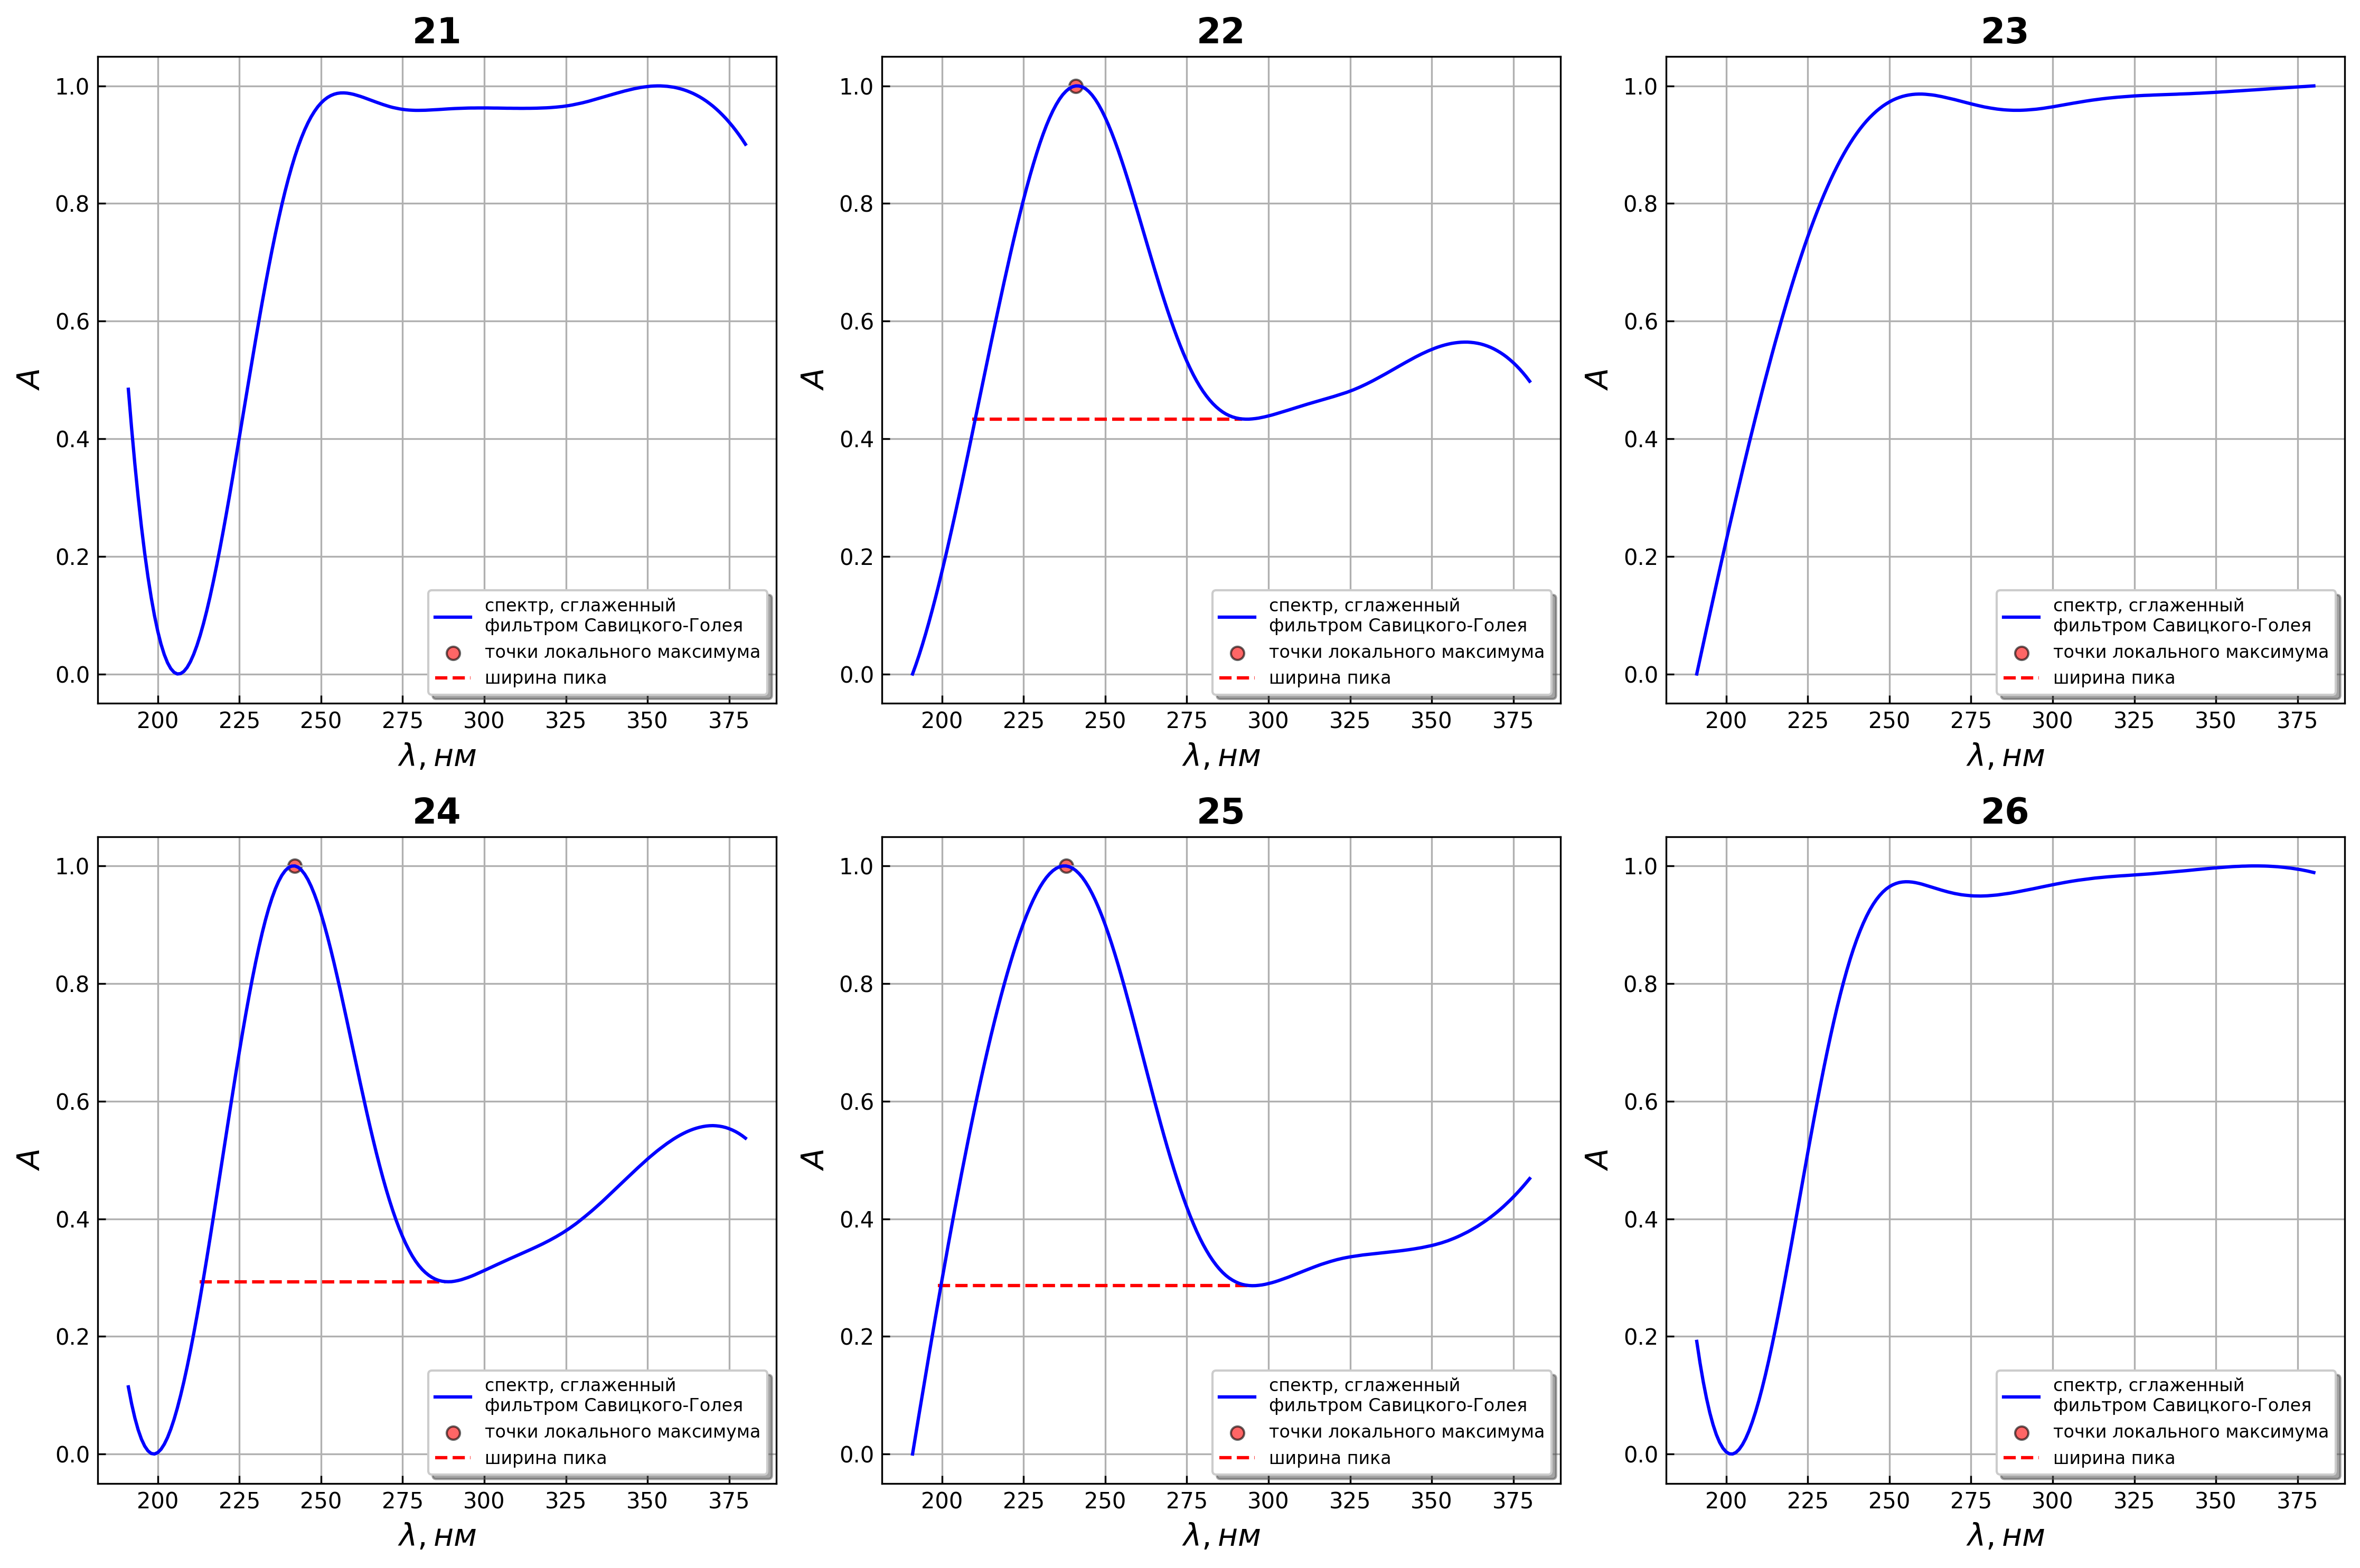

In [191]:
color1 = 'blue'  # generate_color()
color2 = 'red'  # generate_color()

nrows = 2
ncols = 3
index = 1

fig = plt.figure(figsize=(15, 10), dpi=300, linewidth=1.0)

for i in range(len(Y_smooth)):
    plt.subplot(nrows, ncols, index)
    plt.grid(True)
    plt.tick_params(direction='in')
    ax = fig.gca()
    ax.set_title(sp_id[i+1], fontname='DejaVu Sans', fontsize=16, fontweight='bold')
    ax.plot(X[:-1],
            Y_smooth_der1_smooth[i],
            color=color1,
            linewidth=1.5,
            label='спектр, сглаженный \nфильтром Савицкого-Голея')
    ax.scatter(x=X_max[i],
                y=Y_max[i],
                marker='o',
                color=color2,
                edgecolor='black',
                alpha=0.6,
                label='точки локального максимума')
    ax.hlines(*W[i],
              linewidth=1.5,
              linestyle='dashed',
              color=color2,
              label='ширина пика')
    ax.set_xlabel('$λ, нм$', fontname='DejaVu Sans', fontsize=14)
    ax.set_ylabel('$A$', fontname='DejaVu Sans', fontsize=14)
    plt.legend(loc='lower right', fancybox=True, shadow=True, prop={'size': 8})
    index += 1
plt.tight_layout()
plt.savefig('results/uv_ego/all_der1_uv_spectra.png')
plt.show()

In [157]:
def expand_array(arr, n_iterations=1):
    for n in range(n_iterations):
        index = 1
        for i in range(1, len(arr)):
            mid_el = (arr[index] + arr[index-1]) / 2
            arr.insert(index, mid_el)
            index += 2
    return arr

In [195]:
uv_id_lst = list(sp_id.values())
area = [trapz(y, X[::-1]) for y in Y_smooth]
area_d1 = [trapz(y, X[:-1][::-1]) for y in Y_smooth_der1_smooth]

In [202]:
data = {'curve_id': uv_id_lst,
        'area': area,
       'area_d1': area_d1}

In [203]:
df_uv_ego = pd.DataFrame(data=data)
df_uv_ego

,curve_id,area,area_d1
0,﻿21,21.466244,150.15055
1,22,101.538961,107.51800
2,23,32.367090,163.12280
3,24,93.718174,89.52440
4,25,84.577470,94.15355
5,26,31.023524,152.33205


[Text(0.5, 0, 'area'), Text(1.5, 0, 'area_d1')]

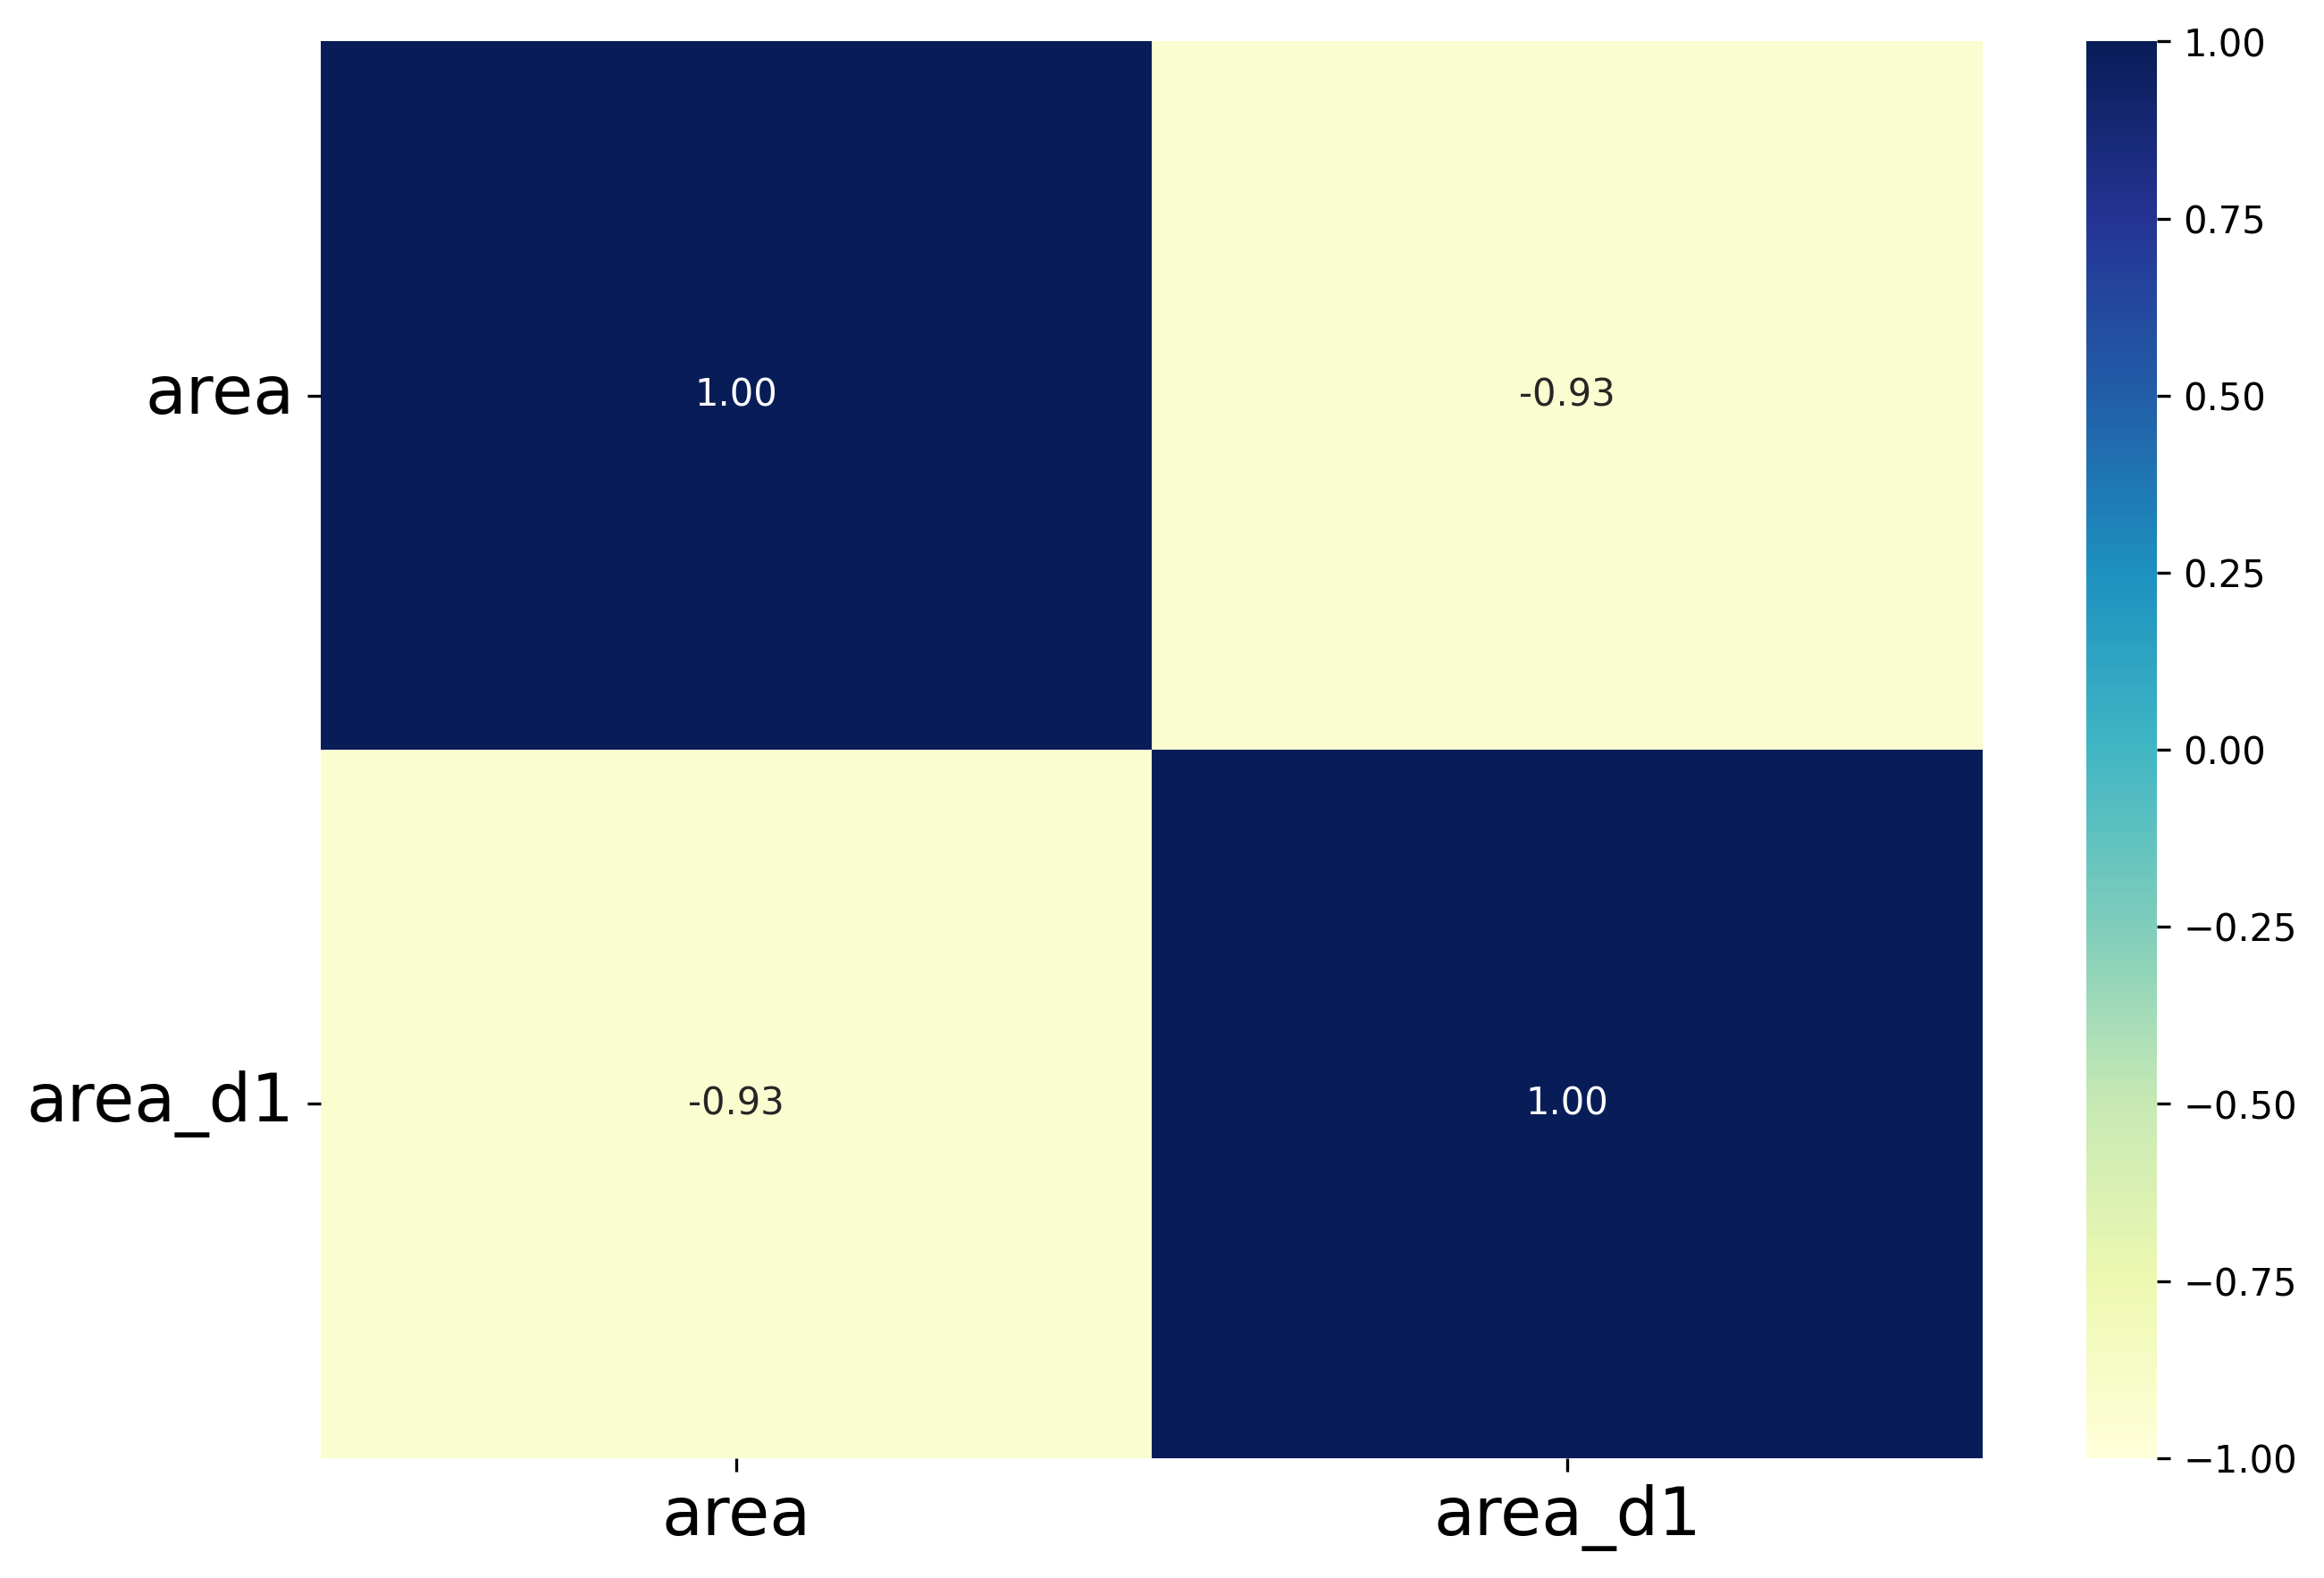

In [199]:
corr = df_uv_ego.corr()
plt.figure(figsize=(10, 7), dpi=300)
corr_plot = sns.heatmap(corr,
                        cmap="YlGnBu",
                        annot=True,
                        vmax=1.0,
                        vmin=-1.0,
                        center=0.0,
                        fmt='.2f')
corr_plot.set_yticklabels(corr_plot.get_yticklabels(), rotation=0, fontsize=18)
corr_plot.set_xticklabels(corr_plot.get_xticklabels(), rotation=0, fontsize=18)

In [209]:
def cluster_analysis(data, n_clusters, figsize=(16, 9), save='n', name_of_file='curve', labels=[], max_clusters=8):
    fig, ax = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 5]}, dpi=300)

    inertia = []
    for n_clusts in range(1, max_clusters):
        kmeans = KMeans(n_clusters=n_clusts, init='k-means++', random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    ax[0].grid(False)
    plt.tick_params(direction='in')
    ax[0].set_title(f'Метрика', fontname='Arial', fontsize=20, fontweight='bold')
    ax[0].plot(range(1, max_clusters),
            inertia,
            '-o',
            color='orange')
    ax[0].set_xlabel('$число$ $кластеров$', fontname='Arial', fontsize=16)
    ax[0].set_ylabel('$WCSS$', fontname='Arial', fontsize=16)

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    groups = kmeans.fit_predict(data)
    ax[1].grid(True)
    plt.tick_params(direction='in')
    ax_labels = list(data.columns)
    ax[1].set_title('Кластеризация', fontnem='Arial', fontsize=20, fontweight='bold')
    for i in range(n_clusters):
        color = generate_color()
        x_f = data[groups == i].iloc[:, 0]
        y_f = data[groups == i].iloc[:, 1]
        x_cl = kmeans.cluster_centers_[:, 0][i]
        y_cl = kmeans.cluster_centers_[:, 1][i]
        ax[1].scatter(x=x_f,
                   y=y_f,
                   marker='o',
                   color=color,
                   s=75,
                   edgecolors='black',
                   alpha=0.6,
                   label=f'объекты кластера {i+1}')
        ax[1].scatter(x=x_cl,
                   y=y_cl,
                   marker='^',
                   edgecolors='black',
                   color=color,
                   s=125,
                   label=f'$центроида$ $кластера$ ${i+1}$')
        x_point_cluster = [[x, x_cl] for x in x_f]
        y_point_cluster = [[y, y_cl] for y in y_f]
        for pair_x, pair_y in zip(x_point_cluster, y_point_cluster):
            ax[1].plot(pair_x,
                    pair_y,
                    linewidth=0.7,
                    color=color)
    if len(labels) > 0:
        for label, x, y, i in zip(labels, data.iloc[:, 0], data.iloc[:, 1], range(len(labels))):
            plt.annotate(f'$\\bf{label}$',
                         xy=(x, y),
                         fontsize=6,
                         ha='center',
                         va='center')
    else:
        pass
    ax[1].set_xlabel(ax_labels[0], fontname='Arial', fontsize=16, style='italic')
    ax[1].set_ylabel(ax_labels[1], fontname='Arial', fontsize=16, style='italic')
    plt.legend(prop={'size': 9})
    
    if save.lower() in ['y', 'yes', 'save']:
        plt.savefig(name_of_file, dpi=450)
    plt.show()

In [207]:
"""Кластеризация по первой паре фичей (,)"""
features1 = df_uv_ego.iloc[:, [1, 2]]
features1

,area,area_d1
0,21.466244,150.15055
1,101.538961,107.51800
2,32.367090,163.12280
3,93.718174,89.52440
4,84.577470,94.15355
5,31.023524,152.33205


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


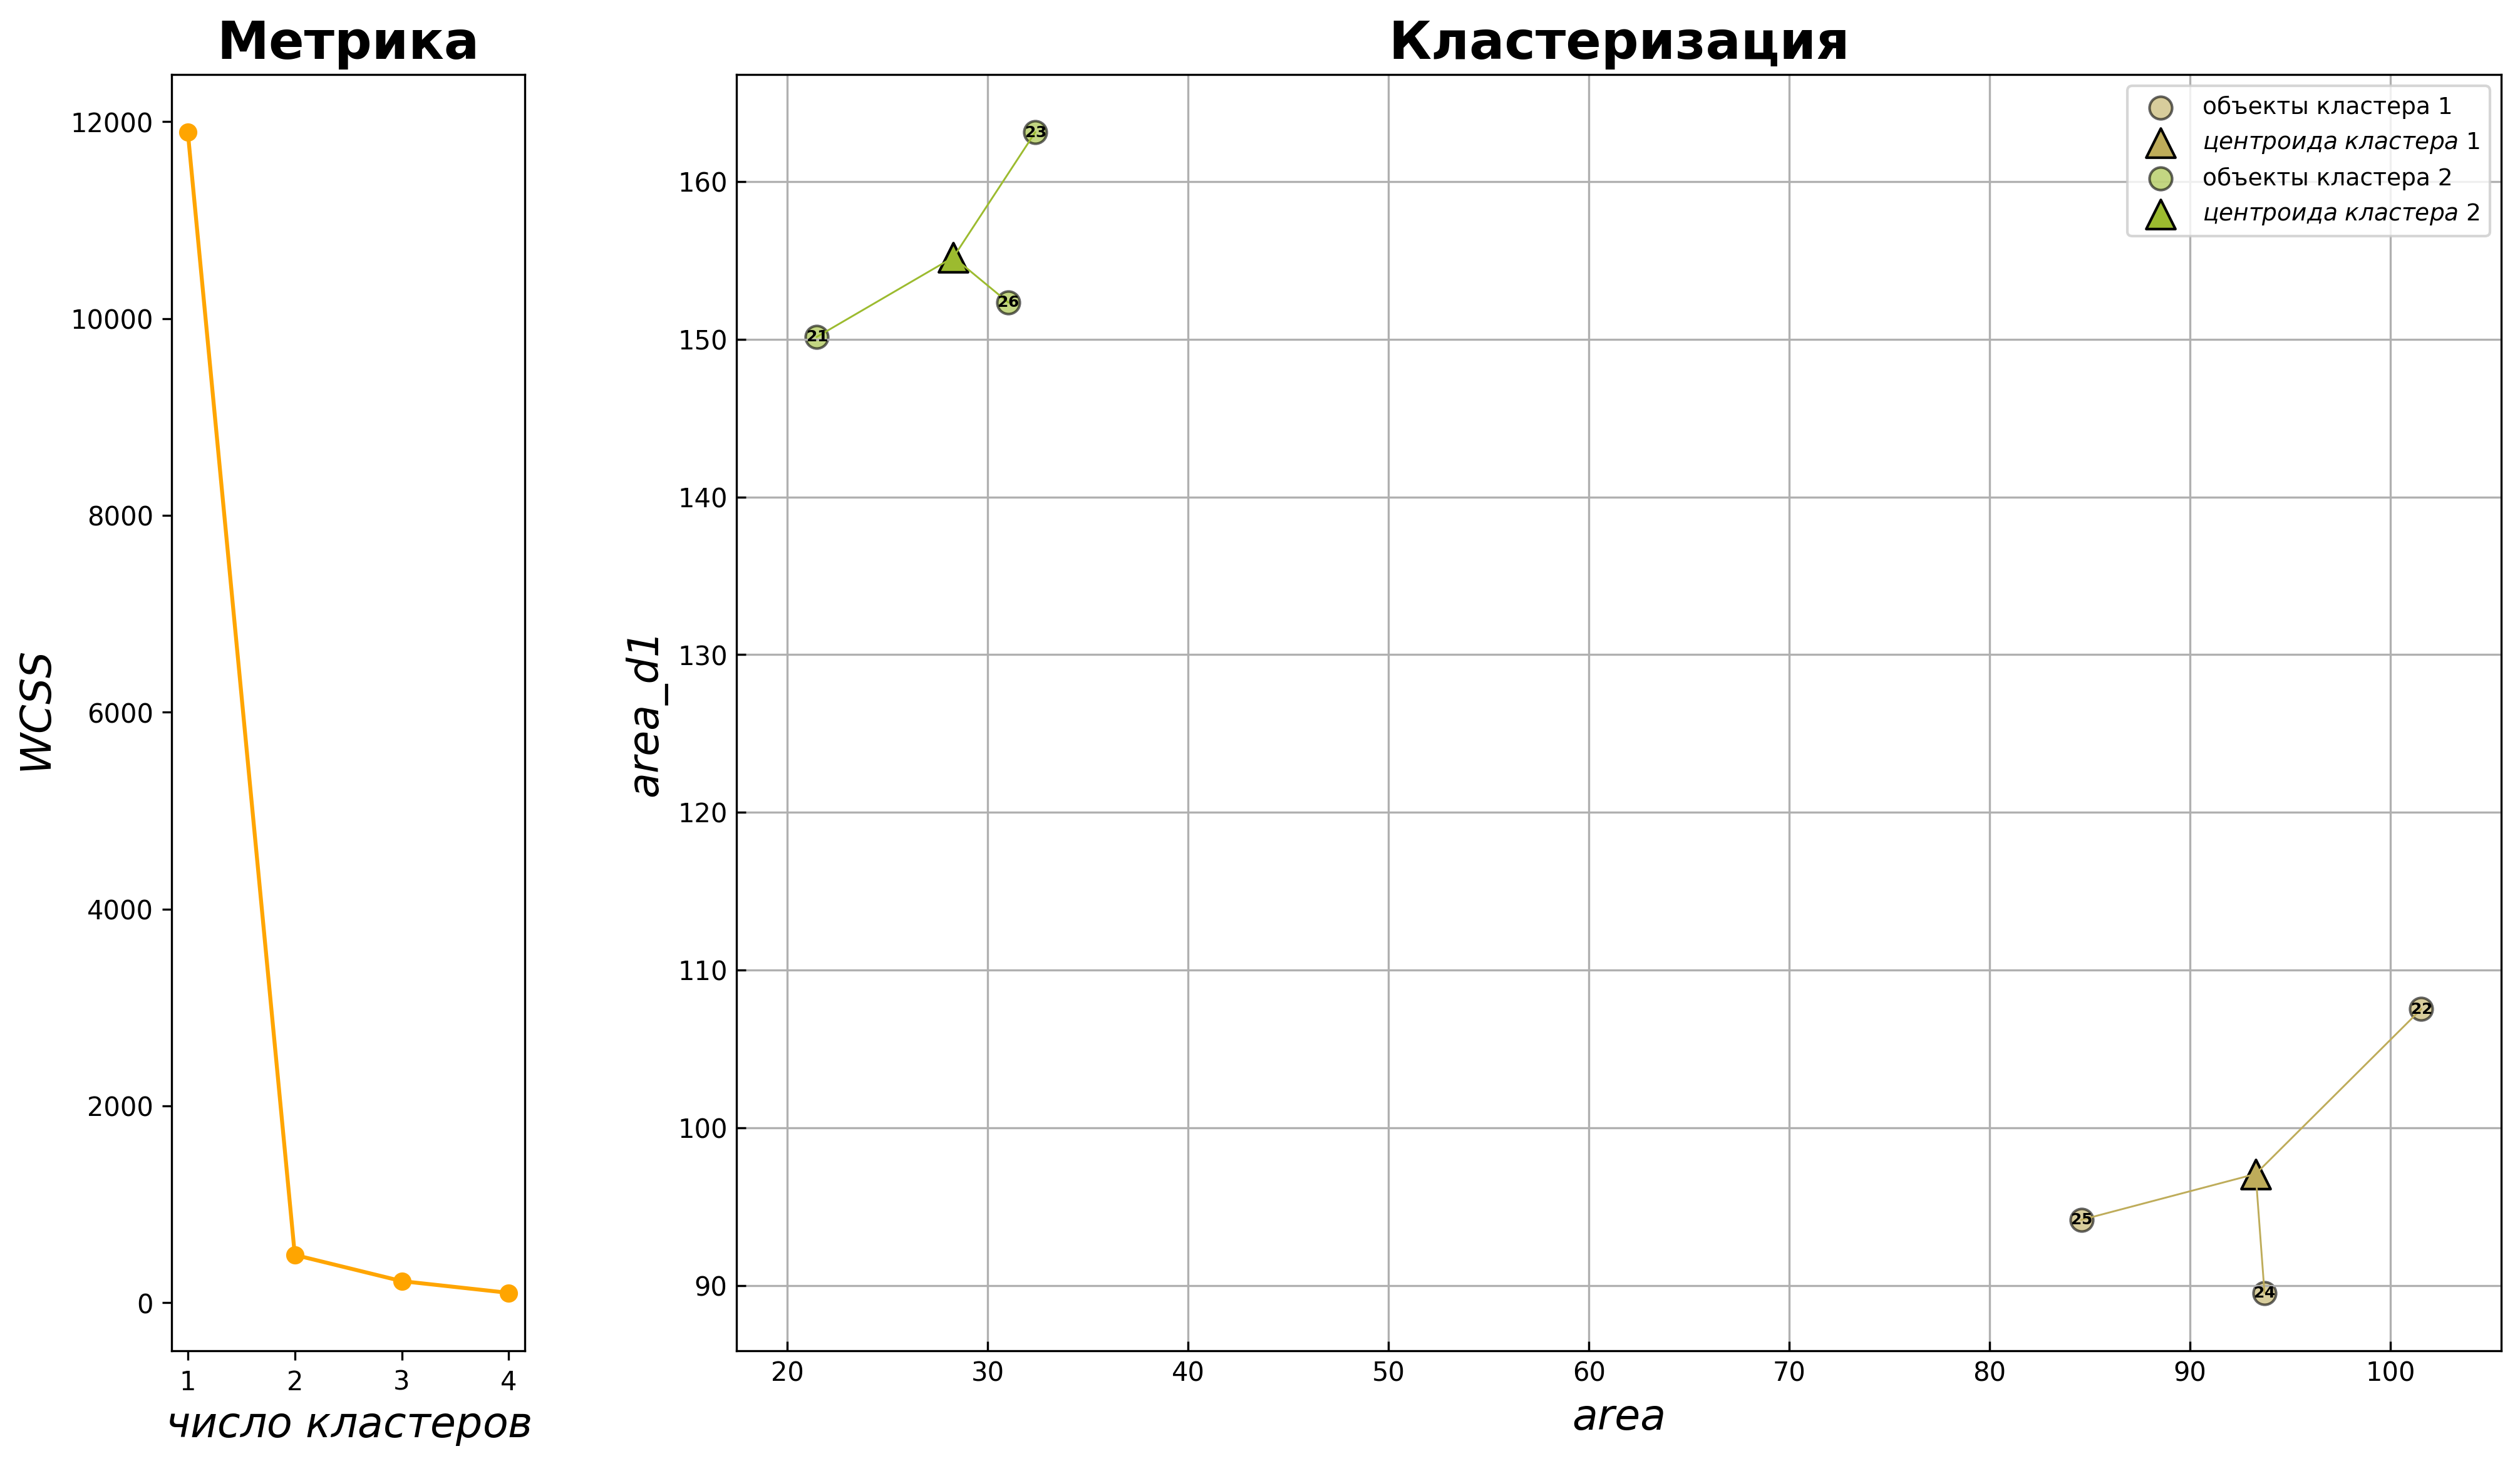

In [210]:
cluster_analysis(data=features1,
                 n_clusters=2,
                 save='y',
                 name_of_file='results/uv_ego/clan_area_aread1',
                 labels=df_uv_ego['curve_id'],
                 max_clusters=5)

In [214]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
groups = kmeans.fit_predict(features1)

res1 = features1.copy()

res1['id'] = df_uv_ego['curve_id']
res1['кластер'] = groups + 1
res1 = res1.iloc[:, 2:].sort_values(by=['кластер'])
res1

,id,кластер
1,22,1
3,24,1
4,25,1
0,﻿21,2
2,23,2
5,26,2
